We start by importing necessary packages.

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg, integrate
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

Dynamic is given by

$$
\dot y = A \, y + f_l(y) + B \, u, \quad y(0) = y_0.
$$

#### 1. Step: Initialize weights and biases

To approximate the feedback control by a neural network, we choose for example the two-layer network:

$$
\mathcal{F}_\theta(y) = W_2 \,(\sigma(W_1\, y + b_1) + y) - W_2 \, \sigma(b_1)
$$

with $\theta = (W_2, W_1, b_1)$.
Note that the particular structure guarantees $\mathcal{F}_\theta(0) = 0$.

#### 2. Step: Main loop

Forward equation (primal state) is given by

$$
\dot y = f(y) + B \, \mathcal F (y), \quad y(0) = y_0.
$$

Backward equation (adjoint state) is given by

$$
-\dot p = Df^*(y) \, p + D_x \mathcal{F}(y) B^* \, p + Q^* \, Q \, y + \beta\,D_x\mathcal{F}(y)^*\, \mathcal{F}(y) \quad p(T) = 0.
$$

## General functions

$$
\theta_0\, N(y,\theta) + \theta_{2L+2}^T y + 1/2 y^T (\theta_{2L} + \theta_{2L}^T) y + \theta_{2L+1}
$$

In [2]:
class NNWeights(object):
    def __init__(self, L, d, m=1, a=1, seed=0, extended=True, zero_control=True):
        
        self.L = L
        self.d = d
        self.m = m
        
        np.random.seed(seed)        
        WL = np.random.randn(m,d)*a
        self.theta = [WL]
        self.extended = extended
        self.zero_control=zero_control
        
        for l in range(1, self.L):
            Wl = np.random.randn(self.d, self.d)*a
            bl = np.random.randn(self.d)*a

            self.theta.append(Wl)
            self.theta.append(bl)
            
        if self.extended:
            self.theta.append(np.random.randn(self.m, self.d, self.d)*a)    
            self.theta.append(np.random.randn(self.m, self.d)*a)
            self.theta.append(np.zeros(self.m))
            
        if self.extended:
            self.ntheta = 2*self.L + 2
        else:
            self.ntheta = 2*self.L - 1

            
    def get_zeros(self):
        
        WL = np.zeros((self.m, self.d))
        ret = [WL]
        for l in range(1, self.L):
            Wl = np.zeros((self.d, self.d))
            bl = np.zeros(self.d)

            ret.append(Wl)
            ret.append(bl)
            
        if self.extended:
            ret.append(np.zeros((self.m, self.d, self.d)))
            ret.append(np.zeros((self.m, self.d)))
            ret.append(np.zeros(self.m))

        return ret
    
    def __add__(self, x):
            
        if isinstance(x, list):
            return [self.theta[l] + x[l] for l in range(self.ntheta)]
        
        elif isinstance(x, NNWeights):
            return [self.theta[l] + x.theta[l] for l in range(self.ntheta)]

    
    def __iadd__(self, x):
        self.theta = self.__add__(x)
        return self
        
    def __mul__(self, x):
        if isinstance(x, (int, float)):
            return [x * self.theta[l] for l in range(self.ntheta)]
        else:
            raise ValueError
        
    __rmul__ = __mul__
        
    def __imul__(self, x):
        self.theta = self.__mul__(x)
        return self
    
    def __str__(self):
        return str(self.theta)

In [3]:
def l2inner(x, y):
    return np.sum(x * y)

def l2norm(x):
    return np.sqrt(np.sum(np.square(x)))


orig_sigma = 1
if orig_sigma:
    def sigma(y):
        ret = np.zeros_like(y)
        idx = y>0
        ret[idx] = np.power(y[idx], 1.01)
        return ret

    def Dsigma(y):
        ret = np.zeros_like(y)
        idx = y>0
        ret[idx] = 1.01*np.power(y[idx], 0.01)
        return ret
else:
    def sigma(y):
        return np.log(np.exp(y)+np.exp(-y))
    
    def Dsigma(y):
        ep = np.exp(y)
        em = np.exp(-y)
        return (ep-em)/(ep+em)

## Examples

<IPython.core.display.Javascript object>


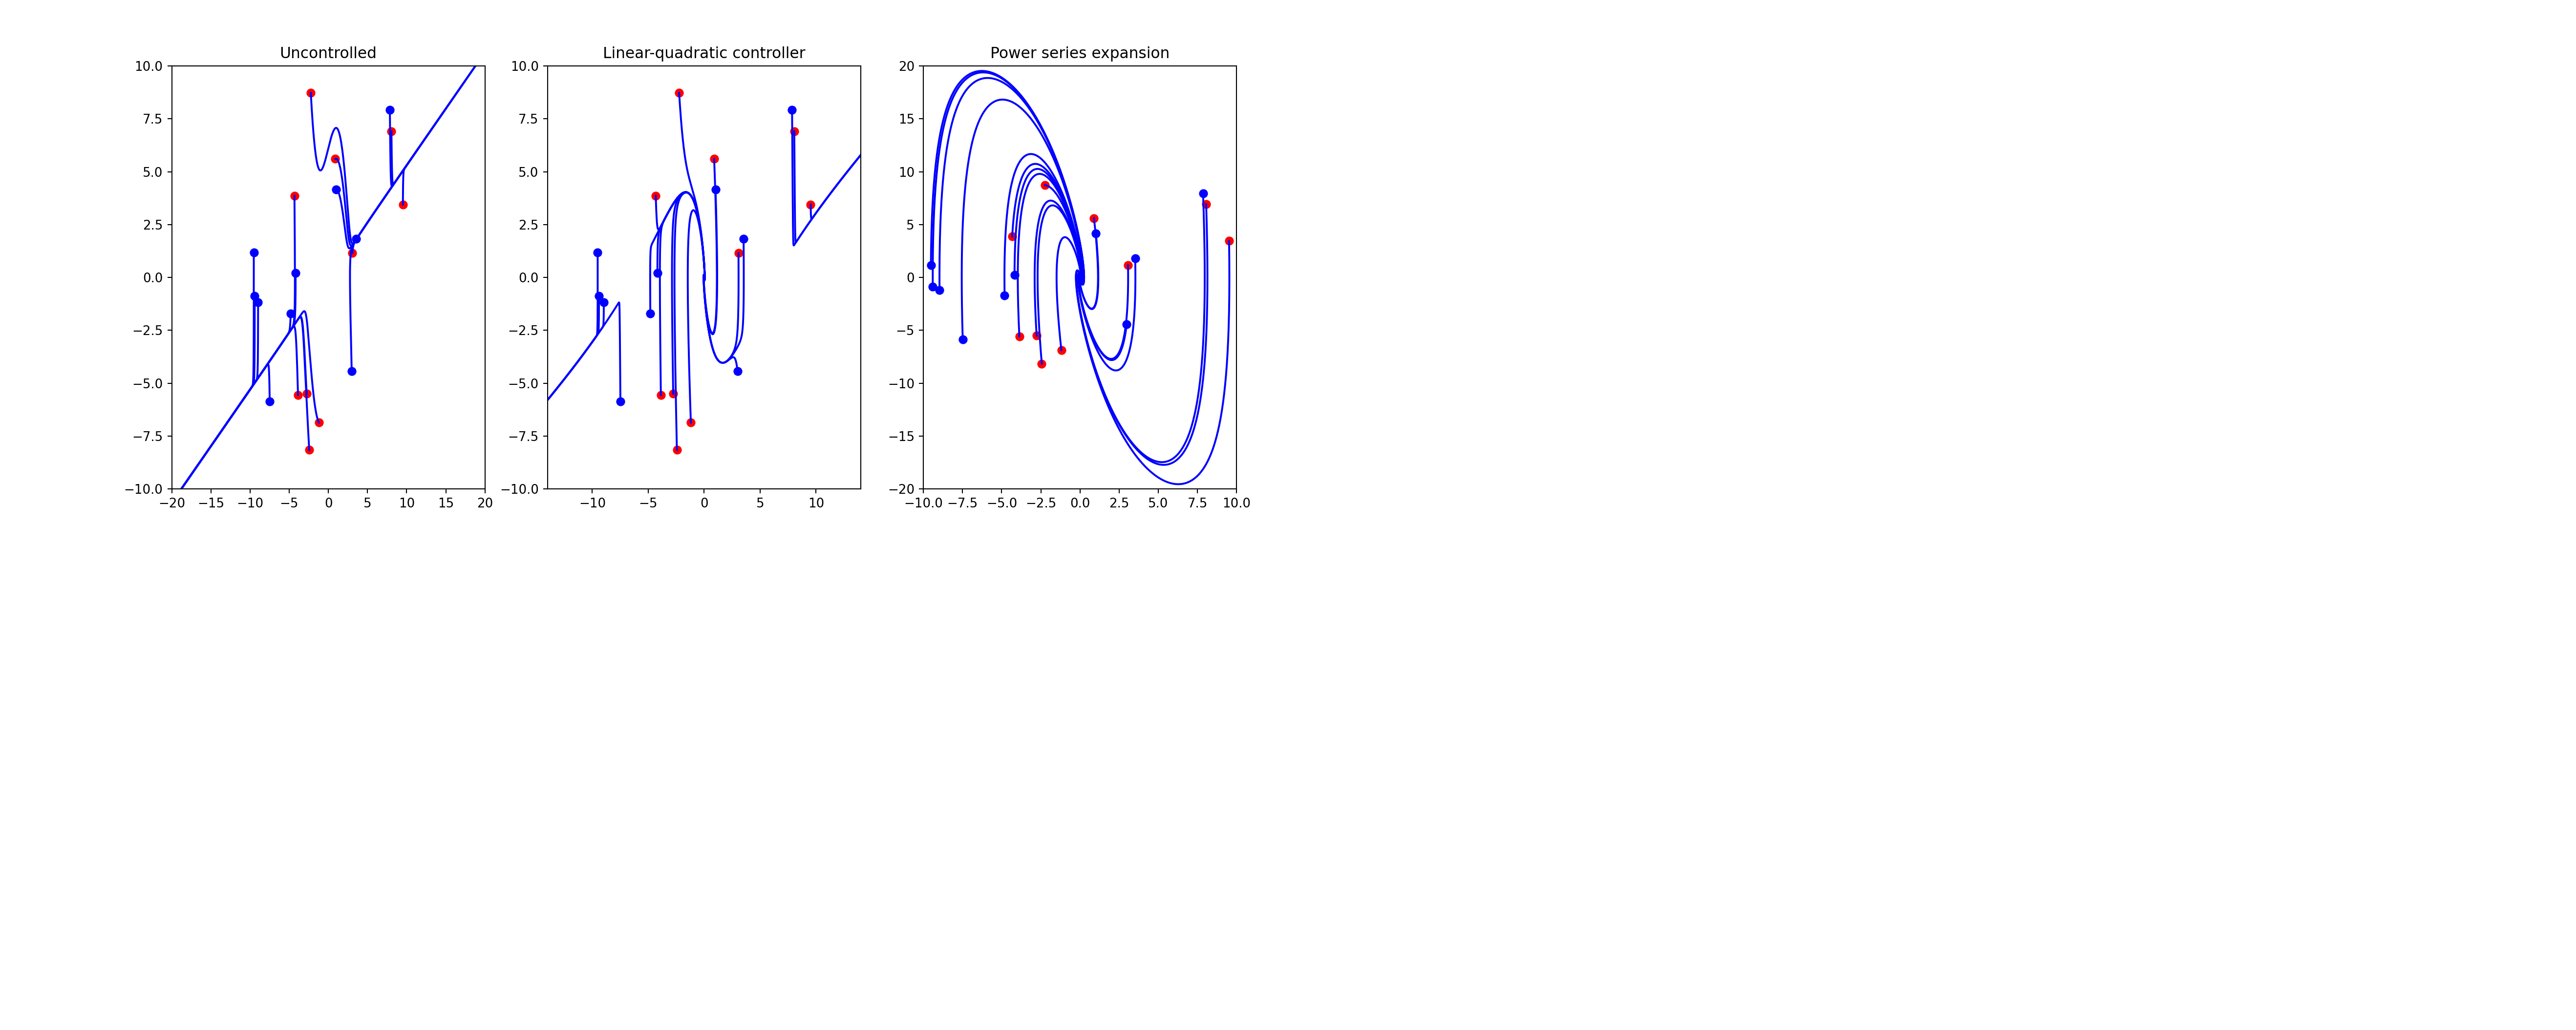

In [4]:
example = 2

# Baseline ode solver
ODESolver = 'BDF'

# Baseline penalty factor and functions
penfac = 1e1
def Dupenalty(y):
    return 0
def Dypenalty(y):
    return 0

# Baseline regularization parameter
alpha = 0.01

if example == 1: # LC-Circuit
    
    A = np.array([[0, 1, -1], [-1, 0, 0], [1, 0, 0]], dtype=np.float64)
    B = np.array([[0], [1], [0]],dtype=np.float64)
    Q = np.eye(3, dtype=np.float64)
    beta = 0.1
    R = beta #*np.eye(3, dtype=np.float64)
    
    
    m = 1 # Control dimension
    d = 3 # State dimension
    
    Ytrain = np.array([[1, 0, 0]], dtype=np.float64)
    Yval = np.array([[-1, 2, 1 ]], dtype=np.float64)
    
    # Final time
    T = 20
    
    # Number of layers
    L = 1
    
    
    # Error level for ode solver
    eps = 1e-13
    ODESolver='RK45'
    
    # Optimal solution obtained by linear-quadratic controller
    Pi = sp.linalg.solve_continuous_are(a=A, b=B, q=Q, r=R)
    Wstar = -1./beta * B.T @ Pi

    def ustar(y):
        return Wstar@y

    def fun(t, y):
        return A @ y + B @ ustar(y)
    
    # Nonlinear part of dynamics
    def f_l(y):
        return np.zeros(d)
                         
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.zeros((d,d))
    
    # Determine explicit solution of first validation point
    tspace = np.linspace(0, T, 2001)
    sol = sp.integrate.solve_ivp(fun, (0,T), Yval[0],
                             method='BDF',
                             rtol=eps, atol=eps, t_eval=tspace)
    
    # Next, we plot the norm of the solution as well as the control
    def solfunc(sol):
        return np.sum(np.square(Q@sol.y),axis=0)
    sol_normsquared=solfunc(sol)

    Ustar = ustar(sol.y).flatten()

    fig, ax = plt.subplots(1,2)
    ax[0].plot(tspace, np.log(sol_normsquared))
    ax[0].set_title('Log of squared norm of $y$: $\log(|Qy(t)|^2)$')
    ax[0].set_xlabel('$t$')
    ax[1].plot(tspace, Ustar)
    ax[1].set_title('Control value $u(t)$')
    ax[1].set_xlabel('$t$');
    
    print('Optimal weights: ', Wstar)
    
    
if example == 2: # Van-der-Pol system
    
    
    m = 1 # Control dimension
    d = 2 # State dimension
    L = 1 # Number of neural network layers
    L = 2
    
    ODESolver = 'BDF'
    penfac = 1e1
    alpha=1.0
    
    def Dupenalty(y):
        return 0
    
    def Dypenalty(y):
        return 0
    
    
    # Inital coordinates for training and validation set
    np.random.seed(3)
    N = 10
    Y = np.random.uniform(np.array([-10,-10]),np.array([10,10]),size=(2*N,2))
    Ytrain = Y[:N]
    Yval = Y[N:]


    fig, axs = plt.subplots(1, 3, figsize=[15,6])
    for ax in axs:
        ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
        ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')


    # Determine uncontrolled orbits
    T = 3
    tspace = np.linspace(0, T, 1001)
    eps = 1e-6

    A = np.array([[0, 1], [-1, 1.5]], dtype=np.float64)
    B = np.array([[0], [1]],dtype=np.float64)
    Q = np.array([[1, 0], [0, 0]], dtype=np.float64)
    beta = 0.001
    R = beta


    # Nonlinear part of dynamics
    def f_l(y):
        return np.array([0, -1.5*(y[0]**2)*y[1] + 0.8*y[0]**3])
    
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.array([[0, 0], [-3*y[0]*y[1]+2.4*y[0]**2, -1.5*y[0]**2]])

    def fun_uncontrolled(t, y):
        return A @ y + f_l(y)

    Pi = sp.linalg.solve_continuous_are(a=A, b=B, q=Q, r=R)
    Wstar = -1./beta * B.T @ Pi

    def F_LQR(y):
        tmp =  -1./beta * B.T @ Pi @y
        return tmp

    def fun_LQR(t, y):
        return fun_uncontrolled(t, y) + B @ F_LQR(y)

    M = np.linalg.inv(A.T - 1./beta * Pi @ B @ B.T)

    def F_PSE(y):
        return -1./beta * B.T @ ( Pi @ y -  M @ Pi @ f_l(y))

    def fun_PSE(t, y):
        return fun_uncontrolled(t, y) + B @ F_PSE(y)

    sol_unc = []
    sol_LQR = []
    sol_PSE = []
    for i in range(20):
        yi_0 = Y[i]
        sol = sp.integrate.solve_ivp(fun_uncontrolled, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        axs[0].plot(sol.y[0], sol.y[1], color='b')
        sol_unc.append(sol)

        sol = sp.integrate.solve_ivp(fun_LQR, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        axs[1].plot(sol.y[0], sol.y[1], color='b')
        sol_LQR.append(sol)

        sol = sp.integrate.solve_ivp(fun_PSE, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        axs[2].plot(sol.y[0], sol.y[1], color='b')
        sol_PSE.append(sol)

    axs[0].set(xlim=(-20,20),ylim=(-10,10))
    axs[0].set(title='Uncontrolled')
    axs[1].set(xlim=(-14,14),ylim=(-10,10))
    axs[1].set(title='Linear-quadratic controller')
    axs[2].set(xlim=(-10,10),ylim=(-20,20));
    axs[2].set(title='Power series expansion');
    
if example == 3: # Collision
    
    
    m = 2 # Control dimension
    d = 2 # State dimension
    L = 1
    ODESolver = 'BDF'
    
    penfac = 1e1
    alpha = 1e-3
    
    # Inital coordinates for training and validation set
    np.random.seed(3)
    N = 10
    Y = np.random.uniform(np.array([-10,-7]),np.array([-6,7]),size=(2*N,2))
    Ytrain = Y[:N]
    Yval = Y[N:]
    
    A = np.array([[0, 0], [0, 0]], dtype=np.float64)
    B = np.array([[1, 0], [0, 1]],dtype=np.float64)

    # State cost
    Q = np.array([[1, 0], [0, 1]], dtype=np.float64)

    # Control cost parameter
    beta = 1.

    # Final time
    T = 10
    tspace = np.linspace(0, T, 1001)
    
    # Nonlinear part of dynamics
    def f_l(y):
        return np.array([0, 0])
    
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.array([[0, 0], [0,0]])
    
    # Error level for ode solver
    eps = 1e-6
    
    # Plot of training and test set
    fig, ax = plt.subplots(1, 1, figsize=[15,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')
    
    # Radius of obstacle
    rad = 1.
    c = np.array([-2.5,.0])

    def ypenalty(y):
        dsq = np.sum(np.square(y-c))
        return np.exp(-1/(rad**2-dsq)) if dsq < rad**2 else 0

    def Dypenalty(y):
        dsq = np.sum(np.square(y-c))
        if dsq < rad**2:
            ret = np.exp(-1/(rad**2 - dsq))
            ret *= np.power(rad**2 - dsq, -2)
            ret *= (-2) * (y-c)
            return ret
        else:
            return np.zeros_like(y)

if example == 4:
    m = 2 # Control dimension
    d = 5 # State dimension
    L = 5
    
    ODESolver = 'RK45'
    
    pi = np.pi
    
    # Inital coordinates for training and validation set
    np.random.seed(3)
    N = 10
    Y = np.random.uniform(np.array([-10, -4, -pi/8, 0., 0]),np.array([-8, 4, pi/8, 1., 0]),size=(2*N,d))
    Ytrain = Y[:N]
    Yval = Y[N:]
    
    A = np.zeros((5,5), dtype=np.float64)
    B = np.array([[0, 0], [0, 0], [0, 0], [1, 0], [0, 1]],dtype=np.float64)

    # State cost
    Q = np.zeros((d, d), dtype=np.float64)
    Q[0,0] = 1 # State x
    Q[1,1] = 1 # State y
    Q[3,3] = 1 # Velocity
    
    #Q[2,2] = 1 # Yaw angle
    #Q[4,4] = 1 # Steering angle

    # Control cost parameter
    beta = 0.001

    # Final time
    T = 10
    tspace = np.linspace(0, T, 1001)
    
    Lc = 1 # Distance rear/front axle
    
    deltamax = pi/8
    wdeltamax = .2
    amax = 3.
                
    def ypenalty(y):
        return .5*(np.maximum(np.abs(y[4])-deltamax, 0))**2
    
    def Dypenalty(y):
        return np.maximum(np.abs(y[4])-deltamax, 0)
    
    def upenalty(u):
        p_a = .5*(np.maximum(np.abs(u[0])-amax, 0))**2
        p_wdelta = .5*(np.maximum(np.abs(u[1])-wdeltamax, 0))**2
        return p_a + p_wdelta
    
    def Dupenalty(u):
        p_a = np.maximum(np.abs(u[0])-amax, 0)
        p_wdelta = np.maximum(np.abs(u[1])-wdeltamax, 0)
        return np.array([p_a, p_wdelta])
        
    # Nonlinear part of dynamics
    def f_l(y):
        return np.array([y[3] * np.cos(y[2]),
                         y[3] * np.sin(y[2]),
                         y[3] / Lc * np.tan(y[4]),
                         0,
                         0])
    
    # Jacobian of nonlinear part
    def Df_l(y):
        return np.array([[0, 0, -y[3] * np.sin(y[2]), np.cos(y[2]), 0],
                         [0, 0, y[3] * np.cos(y[2]), np.sin(y[2]), 0],
                         [0, 0, 0, np.tan(y[4])/Lc, y[3]/Lc * (1+np.tan(y[4])**2)],
                         [0, 0, 0, 0, 0],
                         [0, 0, 0, 0, 0]])
    
    # Error level for ode solver
    eps = 1e-6
    
    # Plot of training and test set
    fig, ax = plt.subplots(1, 1, figsize=[15,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')


## Neural net

In [5]:
# Function class representing feedback laws
def F(Theta, y):

    L = Theta.L
    d = Theta.d
    
    # Forward sweep
    a = y
    if Theta.zero_control:
        a0 = np.zeros_like(y)

    for l in range(1, L):
        Wl = Theta.theta[2*l-1]
        bl = Theta.theta[2*l]

        z = Wl @ a + bl
        a = sigma(z) + a

        if Theta.zero_control:
            z0 = Wl @ a0 + bl
            a0 = sigma(z0) + a0

    WL = Theta.theta[0]

    z = WL @ a
    a = z
    
    # TODO Dim von allen Einzeltermen checken (m-dim)

    if Theta.extended:
        Wq = Theta.theta[2*L-1]
        #a += 0.5 * (y @ (Q+Q.T))@y
        B = Wq + Wq.transpose(0,2,1)
        a += 0.5 * (B @ y) @ y

        b = Theta.theta[2*L]
        a += b@y

        a += Theta.theta[2*L+1]

    if Theta.zero_control:
        z0 = WL @ a0
        a0 = z0
        if Theta.extended:
            a0 += Theta.theta[2*L+1]

    return a - a0 if Theta.zero_control else a

def DxF(Theta, y):

    a = y

    L = Theta.L
    d = Theta.d

    ret = np.eye(d)

    for l in range(1, L):
        Wl = Theta.theta[2*l-1]
        bl = Theta.theta[2*l]

        z = Wl @ a + bl
        ret = (np.diag(Dsigma(z)) @ Wl + np.eye(d)) @ ret

    WL = Theta.theta[0]
    ret = WL @ ret

    if Theta.extended:
        Wq = Theta.theta[2*L-1]
        yv = y.reshape((d,1))
        # TODO Check transposition
        B = Wq + Wq.transpose(0,2,1)
        ret += 0.5*((B@yv).reshape(m, d)+(yv.T @ B).reshape(m, d)).reshape(m,d)

        #ret += (Q+Q.T) @ y
        ret += Theta.theta[2*L]

    return ret

def DthetaF(Theta, y):
    # Order of theta
    # theta = [W_L, W_1, b_1, W_2, b_2, ..., W_{L-1}, b_{L-1}]
    d = Theta.d
    L = Theta.L
    m = Theta.m

    # Forward pass
    a = [y]
    z = []

    if Theta.zero_control:
        a0 = [np.zeros_like(y)]
        z0 = []
        
    for l in range(1, L):
        Wl = Theta.theta[2*l-1]
        bl = Theta.theta[2*l]

        z.append(Wl @ a[-1] + bl)
        a.append(sigma(z[-1]) + a[-1])

        if Theta.zero_control:
            z0.append(Wl @ a0[-1] + bl)
            a0.append(sigma(z0[-1]) + a0[-1])

    WL = Theta.theta[0]

    z.append(WL @ a[-1])
    a.append(z[-1])

    retval = z[-1]
    
    if Theta.extended:
        Wq = Theta.theta[2*L-1]
        B = Wq + Wq.transpose(0,2,1)
        retval += 0.5 * (B @ y) @ y
        #retval += 0.5 * (y @ (Q+Q.T))@y

        b = Theta.theta[2*L]
        retval += b@y

        retval += Theta.theta[2*L+1]

    if Theta.zero_control:
        z0.append(WL @ a0[-1])
        a0.append(z0[-1])
        
        retval -= z0[-1]
        
        if Theta.extended:
            retval -=  Theta.theta[2*L+1]

    # Backward pass
    Ret = [None]*(m)
    for j in range(m):
        ret = [None]*(Theta.ntheta)
        #ret[0] = (a[-2] - a0[-2]).reshape((1,d))
        ret[0] = np.zeros((m,d))

        if Theta.zero_control:
            ret[0][j,:] = a[-2] - a0[-2]
        else:
            ret[0][j,:] = a[-2]

        #ret[0] = np.tile(a[-2] - a0[-2], [m,1])
        delta = WL[j:j+1, :]
        delta0 = WL[j:j+1, :]

        for l in range(1,L):
            Ds = np.diag(Dsigma(z[-1-l]))
            deltaW = delta @ Ds
            DWlF = deltaW.T @ a[-2-l].reshape((1,d))

            if Theta.zero_control:
                Ds0 = np.diag(Dsigma(z0[-1-l]))
                deltaW0 = delta0 @ Ds0
                DWlF -= deltaW0.T @ a0[-2-l].reshape((1,d))
                
            if Theta.extended:
                ret[-2*l-3] = DWlF
            else:
                ret[-2*l] = DWlF

            DblF = deltaW.flatten()

            if Theta.zero_control:
                DblF -= deltaW0.flatten()
                
            if Theta.extended:
                ret[-2*l-2] = DblF
            else:
                ret[-2*l+1] = DblF
            
            if Theta.extended:
                Wl = Theta.theta[-2*l-3]
            else:
                Wl = Theta.theta[-2*l]
                
            delta = delta @ (Ds @ Wl + np.eye(d))

            if Theta.zero_control:
                delta0 = delta0 @ (Ds0 @ Wl + np.eye(d))

        if Theta.extended:
            ret[2*L-1] = np.tile(np.tensordot(y, y, 0), (m, 1, 1))
            ret[2*L] = y
            if Theta.zero_control:
                ret[2*L+1] = np.zeros(1)
            else:
                ret[2*L+1] = np.ones(1)
            
        Ret[j] = ret

    return Ret, retval

## Derived functions

In [6]:
# Forward equations - State

def f(y):
    return A @ y + f_l(y)

def Df(y):
    return A + Df_l(y)

# State equation
def fun_state(t, y, Theta):
    return f(y) + B @ F(Theta, y)

# State equation solver
def solve_state(yi_0, Theta):
    return sp.integrate.solve_ivp(
        fun_state, (0,T), yi_0,
        method=ODESolver,
        rtol=eps,
        atol=eps,
        dense_output=True,
        args=(Theta,))

# Backward equations - Adjoint state

# Adjoint equation
def fun_adjoint(t, p, yi, Theta):
    
    y = yi.sol(T-t)
    tmp = DxF(Theta, y)
    Fy = F(Theta, y)
    Dupen = Dupenalty(Fy)

    t1 = Df(y).T @ p
    t2 = tmp.T @ (B.T @ p + beta * Fy + penfac * Dupen)
    t3 = Q.T @ Q @ y # State cost
    t4 = penfac * Dypenalty(y) # y penalty
    
    ret = t1 + t2 + t3 + t4
    
    return ret

# Hierüber könnte eventuell eine Endbedingung eingehen
def adj_initial(y):
    return np.zeros(d)

# Adjoint state equation solver
def solve_adjoint(yi, Theta):
    return sp.integrate.solve_ivp(
        fun_adjoint, (0,T), adj_initial(yi.sol(T)),
        method=ODESolver,
        rtol=eps,
        atol=eps,
        dense_output=True,
        args=(yi, Theta))

# Gradient equation
def integrate_gradient(yi, pi, Theta):
    
    # Wenn ich hier mit t_eval in state und adjoint equation
    # arbeite, könnte das schneller gehen.
    # Eventuell reicht auch ein kleineres K
    K = 200
    tspace = np.linspace(0, T, K + 1)
    dt = tspace[1]-tspace[0]
    val = Theta.get_zeros()
    L = Theta.L
    
    t = tspace[0]
    
    def theta_val(t):
        y = yi.sol(t)
        p = pi.sol(T-t)
        
        a, Fy = DthetaF(Theta, y)
        b = B.T @ p + beta * Fy
        
        # Das könnte noch effizienter gehen
        ret = [a[0][l] * b[0] for l in range(Theta.ntheta)]
        for i in range(1,m):
            ret = [ret[l] + a[i][l] * b[i] for l in range(Theta.ntheta)]
            
        return ret
    
    valleft = theta_val(t)
    for i in range(K):
        valright = theta_val(tspace[i+1])
        val = [val[l] + dt * .5 * (valleft[l] + valright[l]) for l in range(Theta.ntheta)]
        valleft = valright
    
    # Penalty terms
    # Einfluss von alpha untersuchen
    if Theta.L > 1:
        for i in range(0, Theta.L - 1):

            val[1 + 2*i] += 2 * alpha * Theta.theta[1 + 2*i]
    
    return val

def vec(x):
    ret = np.array(x[0].flatten())
    for i in range(1,len(x)):
        ret = np.append(ret, x[i].flatten())
    return ret

### Check derivative w.r.t. spatial coordinate $y$

In [7]:
#theta = gen_theta(L=L, a=0.1, seed=3)
Theta = NNWeights(L=L, d=d, m=m, a=0.1, seed=3, extended=True, zero_control=True)
y = Yval[0]
Dx = DxF(Theta, y)
h = 1e-8

for i in range(d):
    e = np.zeros(d)
    e[i] = 1
    Dx2 = (F(Theta, y+h*e) - F(Theta, y))/h
    for k in range(m):
        print('Difference: ', Dx[k][i] - Dx2[k])

# Print Dx
print('\n', Dx)
print('DxF in point zero:', DxF(Theta, np.zeros(Theta.d)))
print('F in point zero:', F(Theta, np.zeros(Theta.d)))

Difference:  -8.883733526587889e-08
Difference:  -1.4014146509921943e-08

 [[-0.38691521  1.67347379]]
DxF in point zero: [[0.26699465 0.21460829]]
F in point zero: [0.]


In [8]:
import copy
#y[0] = -100
grad,_ = DthetaF(Theta, y)
h=1e-9
for k in range(m):
    for l in range(2*Theta.L-1):
        print('-----\n', grad[k][l])

        if (l== 0):
            for i in range(m):
                for j in range(d):
                    tplus = copy.deepcopy(Theta)
                    tplus.theta[l][i,j] += h
                    print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
        
        elif (l%2 == 1):
            for i in range(d):
                for j in range(d):
                    tplus = copy.deepcopy(Theta)
                    tplus.theta[l][i,j] += h
                    print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))

        else:
            for i in range(d):
                tplus = copy.deepcopy(Theta)
                tplus.theta[l][i] += h
                print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
        print('-----\n')
    if Theta.extended:
        
        print('-----\nQuadratic part: ', grad[k][2*Theta.L-1])
        for i in range(d):
            for j in range(d):
                tplus = copy.deepcopy(Theta)
                tplus.theta[2*Theta.L-1][k,i,j] += h
                print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
                
        print('-----\nLinear part: ', grad[k][2*Theta.L])
        for i in range(d):
            tplus = copy.deepcopy(Theta)
            tplus.theta[2*Theta.L][k][i] += h
            print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
            
        print('-----\nBias part: ', grad[k][2*Theta.L+1])
        tplus = copy.deepcopy(Theta)
        tplus.theta[2*Theta.L+1] += h
        print(1./h*(F(tplus,y)[k] - F(Theta,y)[k]))
        
print('\nGrad:\n\n', grad)

-----
 [[-4.32949836  3.86275837]]
-4.329498093369465
3.8627585574602104
-----

-----
 [[0. 0.]
 [0. 0.]]
0.0
0.0
0.0
0.0
-----

-----
 [0. 0.]
0.0
0.0
-----

-----
Quadratic part:  [[[ 18.74455609 -16.72380603]
  [-16.72380603  14.9209022 ]]]
18.74455612949077
-16.723806339768995
-16.723806339768995
14.92090273558233
-----
Linear part:  [-4.32949836  3.86275837]
-4.329498093369465
3.8627585574602104
-----
Bias part:  [0.]
0.0

Grad:

 [[array([[-4.32949836,  3.86275837]]), array([[0., 0.],
       [0., 0.]]), array([0., 0.]), array([[[ 18.74455609, -16.72380603],
        [-16.72380603,  14.9209022 ]]]), array([-4.32949836,  3.86275837]), array([0.])]]


## Main loop

In [9]:
restart = 1

In [11]:
from time import time

converged = False
max_iter = 12000



if restart:
    k = 0   

    if example == 1:
        zero_control=1
        extended=0
        Theta = NNWeights(L=L, d=d, m=m, a=0.001, seed=2, extended=extended, zero_control=zero_control)
        Theta.theta[0] *= 0.
        smin=1e-3
        smax=1e-1
        Yt=Ytrain
        
    elif example == 2:
        
        extended = 0
        zero_control = 1
        if L==1:
            Theta = NNWeights(L=L, d=d, m=m, a=0.0, seed=3, extended=extended, zero_control=zero_control)
            smin = 0.1
            smax = 2.
            fac = 1.
            
            if extended:
                smin = 0.0001
                smax = 0.001
            
        else:
            Theta = NNWeights(L=L, d=d, m=m, a=0.0001, seed=3, extended=extended, zero_control=zero_control)
            smin = 0.01
            smax = 0.05
            fac = 1.
            
        Yt = Ytrain*fac
        
    elif example == 3:
        zero_control=1
        extended=1
        Theta = NNWeights(L=L, d=d, m=m, a=0.001, seed=3, extended=extended, zero_control=zero_control)
        smin = 0.000001
        smax = 0.00001
        
    elif example == 4:
        smin = 0.00000001
        smax = 0.0000001
        L = 3
        zero_control=1
        extended=0
        Yt = Ytrain
        
    else:
        zero_control=1
        extended=0
        Theta = NNWeights(L=L, d=d, m=m, a=0.001, seed=2, extended=extended, zero_control=zero_control)
    
N = Yt.shape[0]
while not converged:
    #print('Iteration:', k, end=' ')
    t = time()
    
    # Initialize gradient update
    Dtheta = NNWeights(L=L, d=d, m=m, a=0, extended=extended, zero_control=zero_control)
    # Loop over traning set
    nsamp = 0
    for i in range(N):
        print('.', end='')
        yi_0 = Yt[i]
        
        # Solve state equation for training set
        yi = solve_state(yi_0, Theta)
        
        # Solve adjoint equation for training set
        pi = solve_adjoint(yi, Theta)
        if yi.success & pi.success:
            nsamp += 1
        
            # Update gradient update
            dthetai = integrate_gradient(yi, pi, Theta)
            Dtheta += dthetai
            #[dtheta[l] + dthetai[l] for l in range(2*L-1)]
        else:
            print('Discarded run {}'.format(i))
            print('yi:', yi.message)
            print('pi:', pi.message)
    if nsamp > 0:
        #Dtheta.theta = [Dtheta.theta[l] / nsamp for l in range(2*L-1)]
        Dtheta *= 1/nsamp
    else:
        print('No valid trajectory computed!')
        converged = True
        #print('dtheta: ', dtheta)
    #converged=True
    #break
    print('')
    #print(dtheta)
    #break
    
        
    # Choose stepsize
    if k < 5:
        s = smin
        
    else:
        Ekm1 = vec(Dtheta.theta) - vec(dthetaold)
        Skm1 = vec(Theta.theta) - vec(thetaold)
        S1BB = l2inner(Skm1, Ekm1) / l2inner(Skm1, Skm1)
        S2BB = l2inner(Ekm1, Ekm1) / l2inner(Skm1, Ekm1)
        s1 = np.maximum(smin, np.minimum(S1BB, smax))
        s2 = np.maximum(smin, np.minimum(S2BB, smax))
        s = s1
        #print('Stepsize s = ', s1, ' or ', s2)

    #print('Stepsize s = ', s)
    if k % 20 == 0:
        print('--------------------------')
        print('Iter  Stepsize  ||dtheta||    nsample     Time')
    grad_theta_norm = l2norm(vec(Dtheta.theta))
    print('{:4d}  {:8.4e}  {:8.4e}      {:3d}    {:8.4f}'.format(k, s, grad_theta_norm, nsamp, time()-t), end='\t')

    #print('Norm of gradient = ', l2inner(dW,dW))
    dthetaold = copy.deepcopy(Dtheta.theta)
    thetaold = copy.deepcopy(Theta.theta)
    # Perform gradient step
    #theta -= s * dtheta
    Theta += (-s) * Dtheta
    #*[theta[l] - s * dtheta[l] for l in range(2*L-1)]
    
    if example == 1:
        if grad_theta_norm < 1e-1:
            smin=10.
            smax=50.
        
    if example == 2:   
        
        if L == 1:
            if np.square(grad_theta_norm) < 1e-0:
                smin=10.
                smax=100.
            if np.square(grad_theta_norm) < 1e-1:
                smin=100.
                smax=1000.
        
        if (grad_theta_norm < 1e-1) & (fac+0.1 < 1-1e-13):
            fac += .1
            Yt = Ytrain*fac
            Theta_save = copy.deepcopy(Theta)
            smin = 0.001
            smax = 0.2
            print('Increase training set radius to {}'.format(fac))
        if False & (grad_theta_norm > 5e1):
            print('Decrease step sizes')
            smax = smax*0.5
            smin = smin*0.5
            Theta = copy.deepcopy(Theta_save)

    #print('Iteration: ', k)
    k = k+1
    if k >= max_iter or grad_theta_norm < 1e-6:
        converged = True
        
#theta_save = copy.deepcopy(theta)

..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
   0  1.0000e-02  1.3244e+01       10      1.4178	..........
   1  1.0000e-02  1.3081e+01       10      1.3897	..........
   2  1.0000e-02  1.2963e+01       10      1.4641	..........
   3  1.0000e-02  1.2912e+01       10      1.5455	..........
   4  1.0000e-02  1.2915e+01       10      1.7759	..........
   5  1.0000e-02  1.2963e+01       10      1.6202	..........
   6  1.0000e-02  1.3047e+01       10      1.6041	..........
   7  1.0000e-02  1.3155e+01       10      1.5813	..........
   8  1.0000e-02  1.3279e+01       10      1.5793	..........
   9  1.0000e-02  1.3408e+01       10      1.5623	..........
  10  1.0000e-02  1.3529e+01       10      1.5648	..........
  11  1.0000e-02  1.3628e+01       10      1.5664	..........
  12  1.0000e-02  1.3687e+01       10      1.5290	..........
  13  5.0000e-02  1.3670e+01       10      1.6351	..........
  14  5.0000e-02  1.1888e+01       10      1.8601	..........


 125  1.0000e-02  1.6910e+00       10      2.1164	..........
 126  1.0000e-02  1.6910e+00       10      2.1748	..........
 127  1.0000e-02  1.6910e+00       10      2.2532	..........
 128  1.0000e-02  1.6911e+00       10      2.3470	..........
 129  1.0000e-02  1.6911e+00       10      2.3517	..........
 130  1.0000e-02  1.6911e+00       10      2.5133	..........
 131  1.0000e-02  1.6912e+00       10      3.3020	..........
 132  1.0000e-02  1.6912e+00       10      3.3847	..........
 133  1.0000e-02  1.6913e+00       10      2.4216	..........
 134  1.0000e-02  1.6914e+00       10      2.8618	..........
 135  1.0000e-02  1.6914e+00       10      2.2468	..........
 136  1.0000e-02  1.6915e+00       10      2.9929	..........
 137  1.0000e-02  1.6916e+00       10      2.7435	..........
 138  5.0000e-02  1.6898e+00       10      2.0993	..........
 139  1.0000e-02  1.6902e+00       10      2.6884	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
 140  5.000

 252  5.0000e-02  2.6627e+00       10      2.9385	..........
 253  5.0000e-02  2.6191e+00       10      2.5062	..........
 254  5.0000e-02  2.6104e+00       10      3.1205	..........
 255  5.0000e-02  2.6691e+00       10      2.2560	..........
 256  5.0000e-02  2.5985e+00       10      2.4782	..........
 257  5.0000e-02  2.7047e+00       10      2.3453	..........
 258  5.0000e-02  2.8777e+00       10      2.6296	..........
 259  5.0000e-02  2.7996e+00       10      2.6664	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
 260  5.0000e-02  2.7032e+00       10      2.4100	..........
 261  5.0000e-02  2.8155e+00       10      2.2824	..........
 262  5.0000e-02  2.8516e+00       10      2.6674	..........
 263  5.0000e-02  2.8792e+00       10      2.4193	..........
 264  5.0000e-02  2.9972e+00       10      2.9686	..........
 265  5.0000e-02  2.9613e+00       10      2.4889	..........
 266  5.0000e-02  2.8842e+00       10      2.3780	..........
 267  5.000

 379  5.0000e-02  6.2483e+00       10      2.9962	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
 380  5.0000e-02  6.2492e+00       10      3.0142	..........
 381  5.0000e-02  6.3161e+00       10      2.8785	..........
 382  5.0000e-02  6.4088e+00       10      2.9812	..........
 383  5.0000e-02  6.5881e+00       10      2.8510	..........
 384  5.0000e-02  6.6659e+00       10      3.0288	..........
 385  5.0000e-02  6.6029e+00       10      2.8612	..........
 386  5.0000e-02  6.5267e+00       10      2.9535	..........
 387  5.0000e-02  6.3659e+00       10      3.1263	..........
 388  5.0000e-02  6.2943e+00       10      3.1148	..........
 389  5.0000e-02  6.1524e+00       10      2.7476	..........
 390  5.0000e-02  6.1646e+00       10      2.6863	..........
 391  5.0000e-02  6.0765e+00       10      2.4784	..........
 392  5.0000e-02  5.9928e+00       10      2.9566	..........
 393  5.0000e-02  5.8503e+00       10      2.4997	..........
 394  5.000

 504  5.0000e-02  6.8641e-01       10      2.4313	..........
 505  4.7006e-02  6.8490e-01       10      2.3828	..........
 506  5.0000e-02  6.8284e-01       10      2.4476	..........
 507  5.0000e-02  6.8068e-01       10      2.4117	..........
 508  5.0000e-02  6.7856e-01       10      2.6305	..........
 509  5.0000e-02  6.7646e-01       10      2.4287	..........
 510  5.0000e-02  6.7439e-01       10      2.4070	..........
 511  5.0000e-02  6.7235e-01       10      2.4470	..........
 512  5.0000e-02  6.7032e-01       10      2.4287	..........
 513  5.0000e-02  6.6832e-01       10      2.4049	..........
 514  5.0000e-02  6.6634e-01       10      2.4233	..........
 515  5.0000e-02  6.6437e-01       10      2.6687	..........
 516  4.5766e-02  6.6294e-01       10      2.4462	..........
 517  5.0000e-02  6.6112e-01       10      2.4037	..........
 518  5.0000e-02  6.5916e-01       10      2.3863	..........
 519  5.0000e-02  6.5722e-01       10      2.4312	..........
------------------------

 631  4.0846e-02  5.0599e-01       10      2.4030	..........
 632  4.0578e-02  5.0516e-01       10      2.6363	..........
 633  4.0380e-02  5.0433e-01       10      2.6874	..........
 634  4.0155e-02  5.0351e-01       10      2.5408	..........
 635  4.0015e-02  5.0270e-01       10      2.4792	..........
 636  3.9838e-02  5.0190e-01       10      2.4480	..........
 637  3.9672e-02  5.0111e-01       10      2.4291	..........
 638  3.9535e-02  5.0032e-01       10      2.4460	..........
 639  3.9407e-02  4.9954e-01       10      2.3186	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
 640  2.4127e-02  4.9914e-01       10      2.8201	..........
 641  4.1653e-02  4.9865e-01       10      2.5903	..........
 642  4.0102e-02  4.9782e-01       10      2.4177	..........
 643  3.9883e-02  4.9703e-01       10      2.3332	..........
 644  3.9652e-02  4.9624e-01       10      2.2750	..........
 645  3.9451e-02  4.9546e-01       10      2.2736	..........
 646  3.922

 758  3.1714e-02  4.3424e-01       10      2.4086	..........
 759  3.1689e-02  4.3380e-01       10      2.2796	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
 760  3.1589e-02  4.3337e-01       10      2.2850	..........
 761  3.1599e-02  4.3293e-01       10      2.4659	..........
 762  3.1540e-02  4.3250e-01       10      2.3395	..........
 763  3.1433e-02  4.3207e-01       10      2.2818	..........
 764  3.1432e-02  4.3165e-01       10      2.3103	..........
 765  3.1387e-02  4.3122e-01       10      2.2949	..........
 766  3.1332e-02  4.3080e-01       10      2.2720	..........
 767  2.0894e-02  4.3054e-01       10      2.2520	..........
 768  3.1788e-02  4.3026e-01       10      2.4836	..........
 769  3.1502e-02  4.2983e-01       10      2.3008	..........
 770  3.1382e-02  4.2940e-01       10      2.2656	..........
 771  3.1371e-02  4.2898e-01       10      2.3047	..........
 772  3.1308e-02  4.2856e-01       10      2.2841	..........
 773  3.123

 883  2.7353e-02  3.9060e-01       10      1.9294	..........
 884  2.7267e-02  3.9031e-01       10      1.9006	..........
 885  2.7258e-02  3.9002e-01       10      1.9259	..........
 886  2.7218e-02  3.8973e-01       10      1.8828	..........
 887  2.7201e-02  3.8944e-01       10      1.9547	..........
 888  2.7140e-02  3.8915e-01       10      1.9475	..........
 889  2.7145e-02  3.8886e-01       10      2.3901	..........
 890  2.7106e-02  3.8858e-01       10      2.0127	..........
 891  2.7075e-02  3.8829e-01       10      1.9468	..........
 892  2.7061e-02  3.8801e-01       10      1.8828	..........
 893  2.7033e-02  3.8772e-01       10      2.0257	..........
 894  2.6987e-02  3.8744e-01       10      2.3387	..........
 895  2.6966e-02  3.8716e-01       10      2.1567	..........
 896  2.6932e-02  3.8688e-01       10      2.2135	..........
 897  2.6915e-02  3.8660e-01       10      2.4298	..........
 898  2.6897e-02  3.8632e-01       10      2.2308	..........
 899  2.6856e-02  3.8604

1010  2.4316e-02  3.5897e-01       10      1.8052	..........
1011  2.4298e-02  3.5876e-01       10      1.8168	..........
1012  2.4256e-02  3.5855e-01       10      1.7743	..........
1013  2.4252e-02  3.5834e-01       10      1.8118	..........
1014  2.4200e-02  3.5813e-01       10      1.8541	..........
1015  2.4174e-02  3.5792e-01       10      1.8096	..........
1016  2.4183e-02  3.5771e-01       10      1.8270	..........
1017  2.4148e-02  3.5750e-01       10      1.8845	..........
1018  2.4120e-02  3.5729e-01       10      1.9136	..........
1019  2.4106e-02  3.5708e-01       10      1.8884	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1020  2.4082e-02  3.5688e-01       10      1.8579	..........
1021  2.4068e-02  3.5667e-01       10      1.8720	..........
1022  2.4052e-02  3.5646e-01       10      1.8663	..........
1023  2.4008e-02  3.5626e-01       10      1.8722	..........
1024  2.4037e-02  3.5605e-01       10      1.8564	..........
1025  2.393

1137  2.2041e-02  3.3527e-01       10      2.0621	..........
1138  2.2056e-02  3.3511e-01       10      2.1177	..........
1139  2.2050e-02  3.3495e-01       10      2.3027	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1140  2.2042e-02  3.3479e-01       10      1.8668	..........
1141  2.2013e-02  3.3462e-01       10      1.9560	..........
1142  2.2009e-02  3.3446e-01       10      1.9450	..........
1143  2.1999e-02  3.3430e-01       10      1.9476	..........
1144  2.1993e-02  3.3414e-01       10      1.9125	..........
1145  2.1963e-02  3.3398e-01       10      1.9708	..........
1146  2.1923e-02  3.3382e-01       10      1.9680	..........
1147  2.1944e-02  3.3365e-01       10      1.9599	..........
1148  2.1908e-02  3.3349e-01       10      1.9217	..........
1149  2.1906e-02  3.3333e-01       10      1.9486	..........
1150  2.1892e-02  3.3317e-01       10      1.9723	..........
1151  2.1877e-02  3.3301e-01       10      1.9578	..........
1152  2.185

1262  2.0432e-02  3.1690e-01       10      1.8267	..........
1263  2.0428e-02  3.1677e-01       10      1.9332	..........
1264  2.0433e-02  3.1664e-01       10      1.9189	..........
1265  2.0395e-02  3.1651e-01       10      1.9285	..........
1266  2.0399e-02  3.1637e-01       10      1.9115	..........
1267  2.0384e-02  3.1624e-01       10      1.9923	..........
1268  2.0379e-02  3.1611e-01       10      1.8607	..........
1269  2.0354e-02  3.1598e-01       10      1.8813	..........
1270  2.0357e-02  3.1585e-01       10      2.0740	..........
1271  2.0329e-02  3.1572e-01       10      2.0810	..........
1272  2.0333e-02  3.1559e-01       10      2.2055	..........
1273  2.0310e-02  3.1546e-01       10      2.0784	..........
1274  2.0300e-02  3.1533e-01       10      2.1944	..........
1275  2.0284e-02  3.1520e-01       10      2.3021	..........
1276  2.0286e-02  3.1507e-01       10      1.9282	..........
1277  2.0270e-02  3.1494e-01       10      1.9775	..........
1278  2.0258e-02  3.1481

1389  1.9105e-02  3.0157e-01       10      1.9297	..........
1390  1.9110e-02  3.0146e-01       10      1.9956	..........
1391  1.9098e-02  3.0135e-01       10      1.9549	..........
1392  1.9082e-02  3.0124e-01       10      1.9641	..........
1393  1.9039e-02  3.0114e-01       10      1.8694	..........
1394  1.9064e-02  3.0103e-01       10      1.8745	..........
1395  1.9060e-02  3.0092e-01       10      1.8998	..........
1396  1.9042e-02  3.0081e-01       10      1.8335	..........
1397  1.9033e-02  3.0070e-01       10      1.9093	..........
1398  1.9024e-02  3.0059e-01       10      2.0001	..........
1399  1.9014e-02  3.0048e-01       10      1.9509	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1400  1.9002e-02  3.0037e-01       10      1.9142	..........
1401  1.8982e-02  3.0026e-01       10      1.8955	..........
1402  1.8989e-02  3.0016e-01       10      2.0451	..........
1403  1.8974e-02  3.0005e-01       10      1.8905	..........
1404  1.896

1516  1.8039e-02  2.8869e-01       10      1.8511	..........
1517  1.7966e-02  2.8859e-01       10      1.8932	..........
1518  1.7987e-02  2.8850e-01       10      1.8692	..........
1519  1.7950e-02  2.8841e-01       10      1.8371	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1520  1.8014e-02  2.8831e-01       10      1.8322	..........
1521  1.7979e-02  2.8822e-01       10      1.8793	..........
1522  1.7969e-02  2.8813e-01       10      1.8827	..........
1523  1.7954e-02  2.8803e-01       10      1.8733	..........
1524  1.7928e-02  2.8794e-01       10      1.8419	..........
1525  1.7970e-02  2.8785e-01       10      1.8622	..........
1526  1.7853e-02  2.8776e-01       10      1.8850	..........
1527  1.7938e-02  2.8766e-01       10      1.8861	..........
1528  1.7939e-02  2.8757e-01       10      1.8774	..........
1529  1.7888e-02  2.8748e-01       10      1.8519	..........
1530  1.7913e-02  2.8739e-01       10      1.8551	..........
1531  1.786

1641  1.7094e-02  2.7780e-01       10      1.8471	..........
1642  1.7087e-02  2.7771e-01       10      1.8605	..........
1643  1.7096e-02  2.7763e-01       10      1.8192	..........
1644  1.7075e-02  2.7755e-01       10      1.8893	..........
1645  1.7062e-02  2.7747e-01       10      1.8459	..........
1646  1.7080e-02  2.7739e-01       10      1.8682	..........
1647  1.7053e-02  2.7731e-01       10      1.8325	..........
1648  1.7059e-02  2.7723e-01       10      1.8052	..........
1649  1.6993e-02  2.7715e-01       10      1.8892	..........
1650  1.7073e-02  2.7707e-01       10      1.7796	..........
1651  1.7027e-02  2.7699e-01       10      1.8086	..........
1652  1.6966e-02  2.7691e-01       10      1.8604	..........
1653  1.7038e-02  2.7683e-01       10      1.8171	..........
1654  1.7021e-02  2.7675e-01       10      1.8826	..........
1655  1.7005e-02  2.7667e-01       10      1.8345	..........
1656  1.6964e-02  2.7659e-01       10      1.8342	..........
1657  1.6984e-02  2.7651

1768  1.6275e-02  2.6828e-01       10      1.8311	..........
1769  1.6247e-02  2.6821e-01       10      1.9019	..........
1770  1.6263e-02  2.6814e-01       10      1.9018	..........
1771  1.6251e-02  2.6807e-01       10      1.8953	..........
1772  1.6247e-02  2.6800e-01       10      1.8363	..........
1773  1.6238e-02  2.6793e-01       10      1.9063	..........
1774  1.6232e-02  2.6786e-01       10      1.8555	..........
1775  1.6228e-02  2.6779e-01       10      1.9602	..........
1776  1.6160e-02  2.6772e-01       10      1.8645	..........
1777  1.6218e-02  2.6765e-01       10      1.8842	..........
1778  1.6211e-02  2.6758e-01       10      1.8895	..........
1779  1.6206e-02  2.6751e-01       10      1.8862	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1780  1.6200e-02  2.6744e-01       10      1.8300	..........
1781  1.6186e-02  2.6737e-01       10      1.8520	..........
1782  1.6187e-02  2.6730e-01       10      1.9452	..........
1783  1.616

1895  1.5579e-02  2.5979e-01       10      1.9133	..........
1896  1.5571e-02  2.5973e-01       10      1.9430	..........
1897  1.5554e-02  2.5966e-01       10      2.0203	..........
1898  1.5568e-02  2.5960e-01       10      1.9500	..........
1899  1.5557e-02  2.5954e-01       10      1.9244	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
1900  1.5549e-02  2.5948e-01       10      1.9541	..........
1901  1.5545e-02  2.5941e-01       10      1.9691	..........
1902  1.5543e-02  2.5935e-01       10      1.7883	..........
1903  1.5535e-02  2.5929e-01       10      1.7718	..........
1904  1.5530e-02  2.5923e-01       10      1.8168	..........
1905  1.5525e-02  2.5916e-01       10      1.7849	..........
1906  1.5515e-02  2.5910e-01       10      1.7937	..........
1907  1.5516e-02  2.5904e-01       10      1.8902	..........
1908  1.5510e-02  2.5898e-01       10      1.8174	..........
1909  1.5506e-02  2.5891e-01       10      1.8370	..........
1910  1.549

2020  1.4975e-02  2.5233e-01       10      1.9004	..........
2021  1.4970e-02  2.5227e-01       10      1.8345	..........
2022  1.4966e-02  2.5221e-01       10      1.9060	..........
2023  1.4938e-02  2.5216e-01       10      1.9382	..........
2024  1.4959e-02  2.5210e-01       10      1.8658	..........
2025  1.4953e-02  2.5205e-01       10      1.9259	..........
2026  1.4944e-02  2.5199e-01       10      1.8840	..........
2027  1.4928e-02  2.5193e-01       10      1.8880	..........
2028  1.4939e-02  2.5188e-01       10      1.9236	..........
2029  1.4939e-02  2.5182e-01       10      1.9011	..........
2030  1.4929e-02  2.5176e-01       10      1.8746	..........
2031  1.4929e-02  2.5171e-01       10      1.8022	..........
2032  1.4918e-02  2.5165e-01       10      1.8261	..........
2033  1.4915e-02  2.5160e-01       10      1.9135	..........
2034  1.4944e-02  2.5154e-01       10      1.9135	..........
2035  1.4904e-02  2.5148e-01       10      1.8679	..........
2036  1.4903e-02  2.5143

2147  1.4409e-02  2.4550e-01       10      1.9031	..........
2148  1.4424e-02  2.4545e-01       10      1.8861	..........
2149  1.4432e-02  2.4540e-01       10      1.9754	..........
2150  1.4409e-02  2.4535e-01       10      1.8989	..........
2151  1.4411e-02  2.4530e-01       10      1.9397	..........
2152  1.4406e-02  2.4524e-01       10      2.0168	..........
2153  1.4428e-02  2.4519e-01       10      1.9659	..........
2154  1.4384e-02  2.4514e-01       10      1.9703	..........
2155  1.4401e-02  2.4509e-01       10      1.9521	..........
2156  1.4405e-02  2.4504e-01       10      1.8491	..........
2157  1.4384e-02  2.4499e-01       10      1.8429	..........
2158  1.4388e-02  2.4494e-01       10      1.9231	..........
2159  1.4383e-02  2.4489e-01       10      2.0354	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
2160  1.4383e-02  2.4484e-01       10      2.0155	..........
2161  1.4389e-02  2.4479e-01       10      1.9789	..........
2162  1.436

2274  1.3949e-02  2.3931e-01       10      1.8035	..........
2275  1.3922e-02  2.3926e-01       10      1.8242	..........
2276  1.3946e-02  2.3922e-01       10      1.8150	..........
2277  1.3936e-02  2.3917e-01       10      1.8515	..........
2278  1.3927e-02  2.3912e-01       10      1.8356	..........
2279  1.3917e-02  2.3908e-01       10      1.7984	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
2280  1.3920e-02  2.3903e-01       10      1.8407	..........
2281  1.3907e-02  2.3898e-01       10      1.8600	..........
2282  1.3906e-02  2.3894e-01       10      1.8838	..........
2283  1.3901e-02  2.3889e-01       10      1.8182	..........
2284  1.3932e-02  2.3885e-01       10      1.7886	..........
2285  1.3884e-02  2.3880e-01       10      1.8475	..........
2286  1.3916e-02  2.3875e-01       10      1.7994	..........
2287  1.3871e-02  2.3871e-01       10      1.8096	..........
2288  1.3909e-02  2.3866e-01       10      1.7831	..........
2289  1.387

2400  1.3529e-02  2.3370e-01       10      2.0746	..........
2401  1.3489e-02  2.3366e-01       10      2.0820	..........
2402  1.3491e-02  2.3362e-01       10      2.0485	..........
2403  1.3497e-02  2.3357e-01       10      1.9958	..........
2404  1.3475e-02  2.3353e-01       10      2.1258	..........
2405  1.3503e-02  2.3349e-01       10      2.1195	..........
2406  1.3488e-02  2.3345e-01       10      2.0649	..........
2407  1.3462e-02  2.3340e-01       10      2.1763	..........
2408  1.3460e-02  2.3336e-01       10      2.0769	..........
2409  1.3487e-02  2.3332e-01       10      2.0657	..........
2410  1.3459e-02  2.3328e-01       10      2.0584	..........
2411  1.3464e-02  2.3323e-01       10      1.9049	..........
2412  1.3465e-02  2.3319e-01       10      2.0048	..........
2413  1.3461e-02  2.3315e-01       10      1.9957	..........
2414  1.3464e-02  2.3311e-01       10      2.0085	..........
2415  1.3420e-02  2.3306e-01       10      2.0641	..........
2416  1.3480e-02  2.3302

2527  1.3129e-02  2.2851e-01       10      2.1097	..........
2528  1.3019e-02  2.2847e-01       10      1.9977	..........
2529  1.3099e-02  2.2843e-01       10      1.8788	..........
2530  1.3099e-02  2.2839e-01       10      1.7978	..........
2531  1.3086e-02  2.2835e-01       10      1.8333	..........
2532  1.3097e-02  2.2832e-01       10      1.9737	..........
2533  1.3091e-02  2.2828e-01       10      1.7990	..........
2534  1.3068e-02  2.2824e-01       10      1.8746	..........
2535  1.3066e-02  2.2820e-01       10      1.8086	..........
2536  1.3052e-02  2.2816e-01       10      1.8416	..........
2537  1.3098e-02  2.2812e-01       10      1.9110	..........
2538  1.3055e-02  2.2808e-01       10      1.8315	..........
2539  1.3039e-02  2.2804e-01       10      1.8012	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
2540  1.3094e-02  2.2800e-01       10      1.8277	..........
2541  1.3054e-02  2.2796e-01       10      1.7632	..........
2542  1.304

2654  1.2740e-02  2.2372e-01       10      1.9384	..........
2655  1.2749e-02  2.2369e-01       10      1.8650	..........
2656  1.2719e-02  2.2365e-01       10      1.8556	..........
2657  1.2681e-02  2.2361e-01       10      1.9093	..........
2658  1.2749e-02  2.2358e-01       10      1.8664	..........
2659  1.2732e-02  2.2354e-01       10      1.8168	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
2660  1.2712e-02  2.2351e-01       10      1.8352	..........
2661  1.2709e-02  2.2347e-01       10      1.8490	..........
2662  1.2707e-02  2.2343e-01       10      1.8327	..........
2663  1.2704e-02  2.2340e-01       10      1.8445	..........
2664  1.2673e-02  2.2336e-01       10      1.8557	..........
2665  1.2700e-02  2.2333e-01       10      1.7892	..........
2666  1.2696e-02  2.2329e-01       10      1.8634	..........
2667  1.2694e-02  2.2325e-01       10      1.8590	..........
2668  1.2689e-02  2.2322e-01       10      1.8344	..........
2669  1.269

2780  1.2396e-02  2.1932e-01       10      1.8439	..........
2781  1.2393e-02  2.1929e-01       10      1.8917	..........
2782  1.2391e-02  2.1925e-01       10      1.9406	..........
2783  1.2388e-02  2.1922e-01       10      1.7910	..........
2784  1.2386e-02  2.1919e-01       10      1.9158	..........
2785  1.2383e-02  2.1915e-01       10      1.8277	..........
2786  1.2380e-02  2.1912e-01       10      1.8893	..........
2787  1.2377e-02  2.1908e-01       10      1.8988	..........
2788  1.2349e-02  2.1905e-01       10      1.9032	..........
2789  1.2372e-02  2.1902e-01       10      1.7557	..........
2790  1.2383e-02  2.1898e-01       10      1.8443	..........
2791  1.2368e-02  2.1895e-01       10      1.9389	..........
2792  1.2364e-02  2.1892e-01       10      1.9305	..........
2793  1.2360e-02  2.1888e-01       10      1.9236	..........
2794  1.2358e-02  2.1885e-01       10      1.9080	..........
2795  1.2357e-02  2.1882e-01       10      1.9022	..........
2796  1.2362e-02  2.1878

2907  1.2099e-02  2.1519e-01       10      1.8790	..........
2908  1.2060e-02  2.1516e-01       10      1.8664	..........
2909  1.2078e-02  2.1513e-01       10      1.8550	..........
2910  1.2079e-02  2.1509e-01       10      1.9546	..........
2911  1.2048e-02  2.1506e-01       10      1.8026	..........
2912  1.2069e-02  2.1503e-01       10      1.8977	..........
2913  1.2060e-02  2.1500e-01       10      1.8150	..........
2914  1.2092e-02  2.1497e-01       10      1.8579	..........
2915  1.2046e-02  2.1494e-01       10      1.8400	..........
2916  1.2148e-02  2.1491e-01       10      1.9309	..........
2917  1.2019e-02  2.1488e-01       10      1.8606	..........
2918  1.2056e-02  2.1484e-01       10      1.9056	..........
2919  1.2053e-02  2.1481e-01       10      1.9180	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
2920  1.2042e-02  2.1478e-01       10      1.8932	..........
2921  1.2061e-02  2.1475e-01       10      1.8482	..........
2922  1.204

3034  1.1794e-02  2.1133e-01       10      1.7695	..........
3035  1.1792e-02  2.1130e-01       10      1.7554	..........
3036  1.1779e-02  2.1127e-01       10      1.8265	..........
3037  1.1824e-02  2.1124e-01       10      1.8259	..........
3038  1.1757e-02  2.1121e-01       10      1.8086	..........
3039  1.1787e-02  2.1118e-01       10      1.8316	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
3040  1.1773e-02  2.1116e-01       10      1.7542	..........
3041  1.1790e-02  2.1113e-01       10      1.8313	..........
3042  1.1791e-02  2.1110e-01       10      1.8112	..........
3043  1.1774e-02  2.1107e-01       10      1.7780	..........
3044  1.1772e-02  2.1104e-01       10      1.8390	..........
3045  1.1732e-02  2.1101e-01       10      1.8288	..........
3046  1.1735e-02  2.1098e-01       10      1.7498	..........
3047  1.1814e-02  2.1095e-01       10      1.7845	..........
3048  1.1769e-02  2.1092e-01       10      1.8288	..........
3049  1.175

3160  1.1519e-02  2.0774e-01       10      1.8133	..........
3161  1.1562e-02  2.0772e-01       10      1.8377	..........
3162  1.1482e-02  2.0769e-01       10      1.7790	..........
3163  1.1547e-02  2.0766e-01       10      1.8218	..........
3164  1.1501e-02  2.0763e-01       10      1.7921	..........
3165  1.1520e-02  2.0761e-01       10      1.7704	..........
3166  1.1482e-02  2.0758e-01       10      1.7835	..........
3167  1.1533e-02  2.0755e-01       10      1.8096	..........
3168  1.1521e-02  2.0752e-01       10      1.7629	..........
3169  1.1493e-02  2.0750e-01       10      1.7935	..........
3170  1.1493e-02  2.0747e-01       10      1.7875	..........
3171  1.1493e-02  2.0744e-01       10      1.7682	..........
3172  1.1486e-02  2.0741e-01       10      1.7871	..........
3173  1.1529e-02  2.0739e-01       10      1.8295	..........
3174  1.1513e-02  2.0736e-01       10      1.8019	..........
3175  1.1487e-02  2.0733e-01       10      1.8152	..........
3176  1.1478e-02  2.0730

3287  1.1248e-02  2.0435e-01       10      1.6602	..........
3288  1.1258e-02  2.0432e-01       10      1.7399	..........
3289  1.1270e-02  2.0429e-01       10      1.7136	..........
3290  1.1306e-02  2.0427e-01       10      1.7499	..........
3291  1.1220e-02  2.0424e-01       10      1.7111	..........
3292  1.1276e-02  2.0422e-01       10      1.8170	..........
3293  1.1261e-02  2.0419e-01       10      1.7543	..........
3294  1.1240e-02  2.0416e-01       10      1.8059	..........
3295  1.1298e-02  2.0414e-01       10      1.8498	..........
3296  1.1241e-02  2.0411e-01       10      1.7877	..........
3297  1.1278e-02  2.0409e-01       10      1.8222	..........
3298  1.1199e-02  2.0406e-01       10      1.7839	..........
3299  1.1229e-02  2.0404e-01       10      1.8015	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
3300  1.1260e-02  2.0401e-01       10      1.8705	..........
3301  1.1224e-02  2.0398e-01       10      1.8462	..........
3302  1.122

3414  1.1021e-02  2.0114e-01       10      1.7921	..........
3415  1.1044e-02  2.0112e-01       10      1.8253	..........
3416  1.1028e-02  2.0110e-01       10      1.7962	..........
3417  1.1019e-02  2.0107e-01       10      1.8161	..........
3418  1.1031e-02  2.0105e-01       10      1.8218	..........
3419  1.0994e-02  2.0102e-01       10      1.7463	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
3420  1.1093e-02  2.0100e-01       10      1.8236	..........
3421  1.0957e-02  2.0097e-01       10      1.8231	..........
3422  1.1038e-02  2.0095e-01       10      1.9512	..........
3423  1.1027e-02  2.0092e-01       10      1.8697	..........
3424  1.1012e-02  2.0090e-01       10      1.9714	..........
3425  1.1039e-02  2.0088e-01       10      1.8547	..........
3426  1.0980e-02  2.0085e-01       10      1.9043	..........
3427  1.1017e-02  2.0083e-01       10      1.8842	..........
3428  1.1003e-02  2.0080e-01       10      1.8430	..........
3429  1.103

3540  1.0792e-02  1.9814e-01       10      1.7176	..........
3541  1.0815e-02  1.9812e-01       10      1.7741	..........
3542  1.0838e-02  1.9810e-01       10      1.8606	..........
3543  1.0805e-02  1.9807e-01       10      1.8271	..........
3544  1.0805e-02  1.9805e-01       10      1.8739	..........
3545  1.0807e-02  1.9803e-01       10      1.8334	..........
3546  1.0802e-02  1.9800e-01       10      1.8996	..........
3547  1.0832e-02  1.9798e-01       10      1.9443	..........
3548  1.0795e-02  1.9796e-01       10      1.8459	..........
3549  1.0838e-02  1.9793e-01       10      1.8690	..........
3550  1.0783e-02  1.9791e-01       10      1.8171	..........
3551  1.0752e-02  1.9789e-01       10      1.7988	..........
3552  1.0800e-02  1.9787e-01       10      1.8105	..........
3553  1.0785e-02  1.9784e-01       10      2.1132	..........
3554  1.0796e-02  1.9782e-01       10      2.1041	..........
3555  1.0802e-02  1.9780e-01       10      2.3580	..........
3556  1.0792e-02  1.9777

3667  1.0603e-02  1.9528e-01       10      1.8028	..........
3668  1.0596e-02  1.9526e-01       10      1.7826	..........
3669  1.0608e-02  1.9523e-01       10      1.8217	..........
3670  1.0604e-02  1.9521e-01       10      1.7748	..........
3671  1.0568e-02  1.9519e-01       10      1.8870	..........
3672  1.0596e-02  1.9517e-01       10      1.8704	..........
3673  1.0595e-02  1.9515e-01       10      1.8086	..........
3674  1.0625e-02  1.9513e-01       10      1.8138	..........
3675  1.0563e-02  1.9510e-01       10      1.8078	..........
3676  1.0596e-02  1.9508e-01       10      1.8187	..........
3677  1.0622e-02  1.9506e-01       10      1.7681	..........
3678  1.0584e-02  1.9504e-01       10      1.7368	..........
3679  1.0539e-02  1.9502e-01       10      1.7608	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
3680  1.0588e-02  1.9499e-01       10      1.8565	..........
3681  1.0586e-02  1.9497e-01       10      1.8107	..........
3682  1.060

3794  1.0442e-02  1.9256e-01       10      1.7684	..........
3795  1.0391e-02  1.9254e-01       10      1.8422	..........
3796  1.0409e-02  1.9252e-01       10      1.7955	..........
3797  1.0436e-02  1.9250e-01       10      1.8174	..........
3798  1.0400e-02  1.9248e-01       10      1.7555	..........
3799  1.0348e-02  1.9246e-01       10      1.8307	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
3800  1.0456e-02  1.9244e-01       10      1.7423	..........
3801  1.0383e-02  1.9242e-01       10      1.7292	..........
3802  1.0354e-02  1.9239e-01       10      1.8308	..........
3803  1.0399e-02  1.9237e-01       10      1.7406	..........
3804  1.0402e-02  1.9235e-01       10      1.7737	..........
3805  1.0397e-02  1.9233e-01       10      1.7688	..........
3806  1.0343e-02  1.9231e-01       10      1.8544	..........
3807  1.0401e-02  1.9229e-01       10      1.8312	..........
3808  1.0398e-02  1.9227e-01       10      1.7882	..........
3809  1.039

3920  1.0220e-02  1.9000e-01       10      1.8475	..........
3921  1.0184e-02  1.8998e-01       10      1.8373	..........
3922  1.0220e-02  1.8996e-01       10      1.8311	..........
3923  1.0250e-02  1.8994e-01       10      1.8243	..........
3924  1.0220e-02  1.8992e-01       10      1.8428	..........
3925  1.0182e-02  1.8990e-01       10      1.8839	..........
3926  1.0235e-02  1.8988e-01       10      1.7494	..........
3927  1.0197e-02  1.8986e-01       10      1.7320	..........
3928  1.0194e-02  1.8984e-01       10      1.7308	..........
3929  1.0259e-02  1.8982e-01       10      1.7889	..........
3930  1.0196e-02  1.8980e-01       10      1.7602	..........
3931  1.0186e-02  1.8978e-01       10      1.7374	..........
3932  1.0179e-02  1.8976e-01       10      1.7345	..........
3933  1.0196e-02  1.8974e-01       10      1.7332	..........
3934  1.0335e-02  1.8972e-01       10      1.8509	..........
3935  1.0235e-02  1.8970e-01       10      1.7295	..........
3936  1.0172e-02  1.8968

4047  1.0059e-02  1.8754e-01       10      1.7317	..........
4048  1.0070e-02  1.8752e-01       10      1.7205	..........
4049  1.0041e-02  1.8750e-01       10      1.7322	..........
4050  1.0000e-02  1.8748e-01       10      1.7244	..........
4051  1.0074e-02  1.8746e-01       10      1.7119	..........
4052  1.0130e-02  1.8744e-01       10      1.7240	..........
4053  1.0088e-02  1.8742e-01       10      1.7852	..........
4054  1.0020e-02  1.8740e-01       10      1.7938	..........
4055  1.0000e-02  1.8738e-01       10      1.7656	..........
4056  1.0050e-02  1.8737e-01       10      1.6911	..........
4057  1.0017e-02  1.8735e-01       10      1.7556	..........
4058  1.0011e-02  1.8733e-01       10      1.7751	..........
4059  1.0068e-02  1.8731e-01       10      1.7695	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
4060  1.0000e-02  1.8729e-01       10      1.7237	..........
4061  1.0008e-02  1.8727e-01       10      1.7124	..........
4062  1.001

4174  1.0000e-02  1.8518e-01       10      2.0331	..........
4175  1.0000e-02  1.8516e-01       10      1.8818	..........
4176  1.0000e-02  1.8514e-01       10      2.0191	..........
4177  1.0000e-02  1.8512e-01       10      1.8951	..........
4178  1.0000e-02  1.8510e-01       10      2.5563	..........
4179  1.0000e-02  1.8509e-01       10      1.8244	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
4180  1.0000e-02  1.8507e-01       10      1.8636	..........
4181  1.0000e-02  1.8505e-01       10      1.8362	..........
4182  1.0000e-02  1.8503e-01       10      1.8234	..........
4183  1.0000e-02  1.8501e-01       10      1.7949	..........
4184  1.0000e-02  1.8499e-01       10      1.9759	..........
4185  1.0000e-02  1.8498e-01       10      2.0307	..........
4186  1.0000e-02  1.8496e-01       10      1.9514	..........
4187  1.0000e-02  1.8494e-01       10      1.9449	..........
4188  1.0000e-02  1.8492e-01       10      1.8233	..........
4189  1.000

4300  1.0000e-02  1.8291e-01       10      1.8632	..........
4301  1.0000e-02  1.8289e-01       10      1.8173	..........
4302  1.0000e-02  1.8287e-01       10      1.7913	..........
4303  1.0000e-02  1.8285e-01       10      1.8792	..........
4304  1.0000e-02  1.8283e-01       10      1.8460	..........
4305  1.0000e-02  1.8282e-01       10      1.8417	..........
4306  1.0000e-02  1.8280e-01       10      1.7758	..........
4307  1.0000e-02  1.8278e-01       10      1.8424	..........
4308  1.0000e-02  1.8276e-01       10      1.8693	..........
4309  1.0000e-02  1.8275e-01       10      1.8149	..........
4310  1.0000e-02  1.8273e-01       10      1.7863	..........
4311  1.0000e-02  1.8271e-01       10      1.8281	..........
4312  1.0000e-02  1.8269e-01       10      1.7792	..........
4313  1.0000e-02  1.8267e-01       10      1.8272	..........
4314  1.0000e-02  1.8266e-01       10      1.7482	..........
4315  1.0000e-02  1.8264e-01       10      1.8329	..........
4316  1.0000e-02  1.8262

4427  1.0000e-02  1.8068e-01       10      1.6990	..........
4428  1.0000e-02  1.8066e-01       10      2.5557	..........
4429  1.0000e-02  1.8065e-01       10      1.7378	..........
4430  1.0000e-02  1.8063e-01       10      1.6938	..........
4431  1.0000e-02  1.8061e-01       10      1.7519	..........
4432  1.0000e-02  1.8059e-01       10      1.7737	..........
4433  1.0000e-02  1.8058e-01       10      1.7394	..........
4434  1.0000e-02  1.8056e-01       10      1.8347	..........
4435  1.0000e-02  1.8054e-01       10      1.7250	..........
4436  1.0000e-02  1.8053e-01       10      1.7805	..........
4437  1.0000e-02  1.8051e-01       10      1.7338	..........
4438  1.0000e-02  1.8049e-01       10      1.7853	..........
4439  1.0000e-02  1.8047e-01       10      1.7230	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
4440  1.0000e-02  1.8046e-01       10      1.7611	..........
4441  1.0000e-02  1.8044e-01       10      1.7077	..........
4442  1.000

4554  1.0000e-02  1.7852e-01       10      1.8017	..........
4555  1.0000e-02  1.7850e-01       10      1.7276	..........
4556  1.0000e-02  1.7849e-01       10      1.7533	..........
4557  1.0000e-02  1.7847e-01       10      1.7872	..........
4558  1.0000e-02  1.7845e-01       10      1.7698	..........
4559  1.0000e-02  1.7844e-01       10      1.7583	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
4560  1.0000e-02  1.7842e-01       10      1.8185	..........
4561  1.0000e-02  1.7840e-01       10      1.7620	..........
4562  1.0000e-02  1.7838e-01       10      1.7504	..........
4563  1.0000e-02  1.7837e-01       10      1.7228	..........
4564  1.0000e-02  1.7835e-01       10      1.7757	..........
4565  1.0000e-02  1.7833e-01       10      1.7703	..........
4566  1.0000e-02  1.7832e-01       10      1.8172	..........
4567  1.0000e-02  1.7830e-01       10      1.7709	..........
4568  1.0000e-02  1.7828e-01       10      1.7276	..........
4569  1.000

4680  1.0000e-02  1.7643e-01       10      1.8907	..........
4681  1.0000e-02  1.7642e-01       10      1.7498	..........
4682  1.0000e-02  1.7640e-01       10      1.7876	..........
4683  1.0000e-02  1.7638e-01       10      1.7519	..........
4684  1.0000e-02  1.7637e-01       10      1.7455	..........
4685  1.0000e-02  1.7635e-01       10      1.7007	..........
4686  1.0000e-02  1.7633e-01       10      1.7639	..........
4687  1.0000e-02  1.7632e-01       10      1.7217	..........
4688  1.0000e-02  1.7630e-01       10      1.7582	..........
4689  1.0000e-02  1.7629e-01       10      1.8532	..........
4690  1.0000e-02  1.7627e-01       10      1.8310	..........
4691  1.0000e-02  1.7625e-01       10      1.7517	..........
4692  1.0000e-02  1.7624e-01       10      1.8122	..........
4693  1.0000e-02  1.7622e-01       10      1.8294	..........
4694  1.0000e-02  1.7620e-01       10      1.8602	..........
4695  1.0000e-02  1.7619e-01       10      1.8270	..........
4696  1.0000e-02  1.7617

4807  1.0000e-02  1.7439e-01       10      1.7519	..........
4808  1.0000e-02  1.7437e-01       10      1.8238	..........
4809  1.0000e-02  1.7435e-01       10      2.2171	..........
4810  1.0000e-02  1.7434e-01       10      2.7030	..........
4811  1.0000e-02  1.7432e-01       10      1.9122	..........
4812  1.0000e-02  1.7431e-01       10      1.9607	..........
4813  1.0000e-02  1.7429e-01       10      1.8244	..........
4814  1.0000e-02  1.7428e-01       10      2.3014	..........
4815  1.0000e-02  1.7426e-01       10      1.8068	..........
4816  1.0000e-02  1.7424e-01       10      1.7589	..........
4817  1.0000e-02  1.7423e-01       10      1.8339	..........
4818  1.0000e-02  1.7421e-01       10      2.0439	..........
4819  1.0000e-02  1.7420e-01       10      1.9110	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
4820  1.0000e-02  1.7418e-01       10      2.2631	..........
4821  1.0000e-02  1.7416e-01       10      2.7937	..........
4822  1.000

4934  1.0000e-02  1.7240e-01       10      1.8030	..........
4935  1.0000e-02  1.7238e-01       10      1.7776	..........
4936  1.0000e-02  1.7236e-01       10      1.7351	..........
4937  1.0000e-02  1.7235e-01       10      1.8192	..........
4938  1.0000e-02  1.7233e-01       10      1.7733	..........
4939  1.0000e-02  1.7232e-01       10      1.7704	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
4940  1.0000e-02  1.7230e-01       10      1.7661	..........
4941  1.0000e-02  1.7229e-01       10      1.8179	..........
4942  1.0000e-02  1.7227e-01       10      1.7616	..........
4943  1.0000e-02  1.7226e-01       10      1.7872	..........
4944  1.0000e-02  1.7224e-01       10      1.8340	..........
4945  1.0000e-02  1.7223e-01       10      1.7565	..........
4946  1.0000e-02  1.7221e-01       10      1.7650	..........
4947  1.0000e-02  1.7219e-01       10      1.7464	..........
4948  1.0000e-02  1.7218e-01       10      1.8065	..........
4949  1.000

5060  1.0000e-02  1.7047e-01       10      1.8611	..........
5061  1.0000e-02  1.7046e-01       10      1.6964	..........
5062  1.0000e-02  1.7044e-01       10      1.6975	..........
5063  1.0000e-02  1.7043e-01       10      1.7343	..........
5064  1.0000e-02  1.7041e-01       10      1.6927	..........
5065  1.0000e-02  1.7040e-01       10      1.7557	..........
5066  1.0000e-02  1.7038e-01       10      1.6954	..........
5067  1.0000e-02  1.7037e-01       10      1.8019	..........
5068  1.0000e-02  1.7035e-01       10      1.8036	..........
5069  1.0000e-02  1.7034e-01       10      1.7762	..........
5070  1.0000e-02  1.7032e-01       10      1.7740	..........
5071  1.0000e-02  1.7031e-01       10      1.7670	..........
5072  1.0000e-02  1.7029e-01       10      1.7279	..........
5073  1.0000e-02  1.7028e-01       10      1.7486	..........
5074  1.0000e-02  1.7026e-01       10      1.7822	..........
5075  1.0000e-02  1.7025e-01       10      1.7472	..........
5076  1.0000e-02  1.7023

5187  1.0000e-02  1.6858e-01       10      1.8248	..........
5188  1.0000e-02  1.6857e-01       10      1.8874	..........
5189  1.0000e-02  1.6855e-01       10      1.8695	..........
5190  1.0000e-02  1.6854e-01       10      1.9171	..........
5191  1.0000e-02  1.6852e-01       10      1.8724	..........
5192  1.0000e-02  1.6851e-01       10      1.8210	..........
5193  1.0000e-02  1.6849e-01       10      1.9633	..........
5194  1.0000e-02  1.6848e-01       10      1.9070	..........
5195  1.0000e-02  1.6846e-01       10      1.8584	..........
5196  1.0000e-02  1.6845e-01       10      1.8428	..........
5197  1.0000e-02  1.6844e-01       10      1.9345	..........
5198  1.0000e-02  1.6842e-01       10      2.0713	..........
5199  1.0000e-02  1.6841e-01       10      1.8909	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
5200  1.0000e-02  1.6839e-01       10      1.8758	..........
5201  1.0000e-02  1.6838e-01       10      1.9872	..........
5202  1.000

5314  1.0000e-02  1.6674e-01       10      1.8076	..........
5315  1.0000e-02  1.6673e-01       10      1.7772	..........
5316  1.0000e-02  1.6671e-01       10      1.8033	..........
5317  1.0000e-02  1.6670e-01       10      1.8126	..........
5318  1.0000e-02  1.6668e-01       10      1.7592	..........
5319  1.0000e-02  1.6667e-01       10      1.7263	..........
--------------------------
Iter  Stepsize  ||dtheta||    nsample     Time
5320  1.0000e-02  1.6665e-01       10      1.9114	..........
5321  1.0000e-02  1.6664e-01       10      1.7632	..........
5322  1.0000e-02  1.6663e-01       10      1.8015	..........
5323  1.0000e-02  1.6661e-01       10      1.7825	..........
5324  1.0000e-02  1.6660e-01       10      2.0308	..........
5325  1.0000e-02  1.6658e-01       10      2.0353	..........
5326  1.0000e-02  1.6657e-01       10      2.0816	..........
5327  1.0000e-02  1.6655e-01       10      2.1574	..........
5328  1.0000e-02  1.6654e-01       10      1.9091	..........
5329  1.000

KeyboardInterrupt: 

## Final output

In [12]:
if example == 1:
    restart = 0
    savefig = False
    
elif example == 2:
    restart = 0
    savefig = False
    poststr = 'new'
    smin = 1e-2
    smax = 1e-1
    plot_comparison = False # Takes some minutes

elif example == 3:
    restart = 0
    savefig = False
    smax = 1e-4
    smin = smax/10
    poststr = 'new'
    
elif example == 4:
    savefig = False
    poststr = 'new'
    restart = 0
    
    smin = 5e-8
    smax = 5e-7

<IPython.core.display.Javascript object>


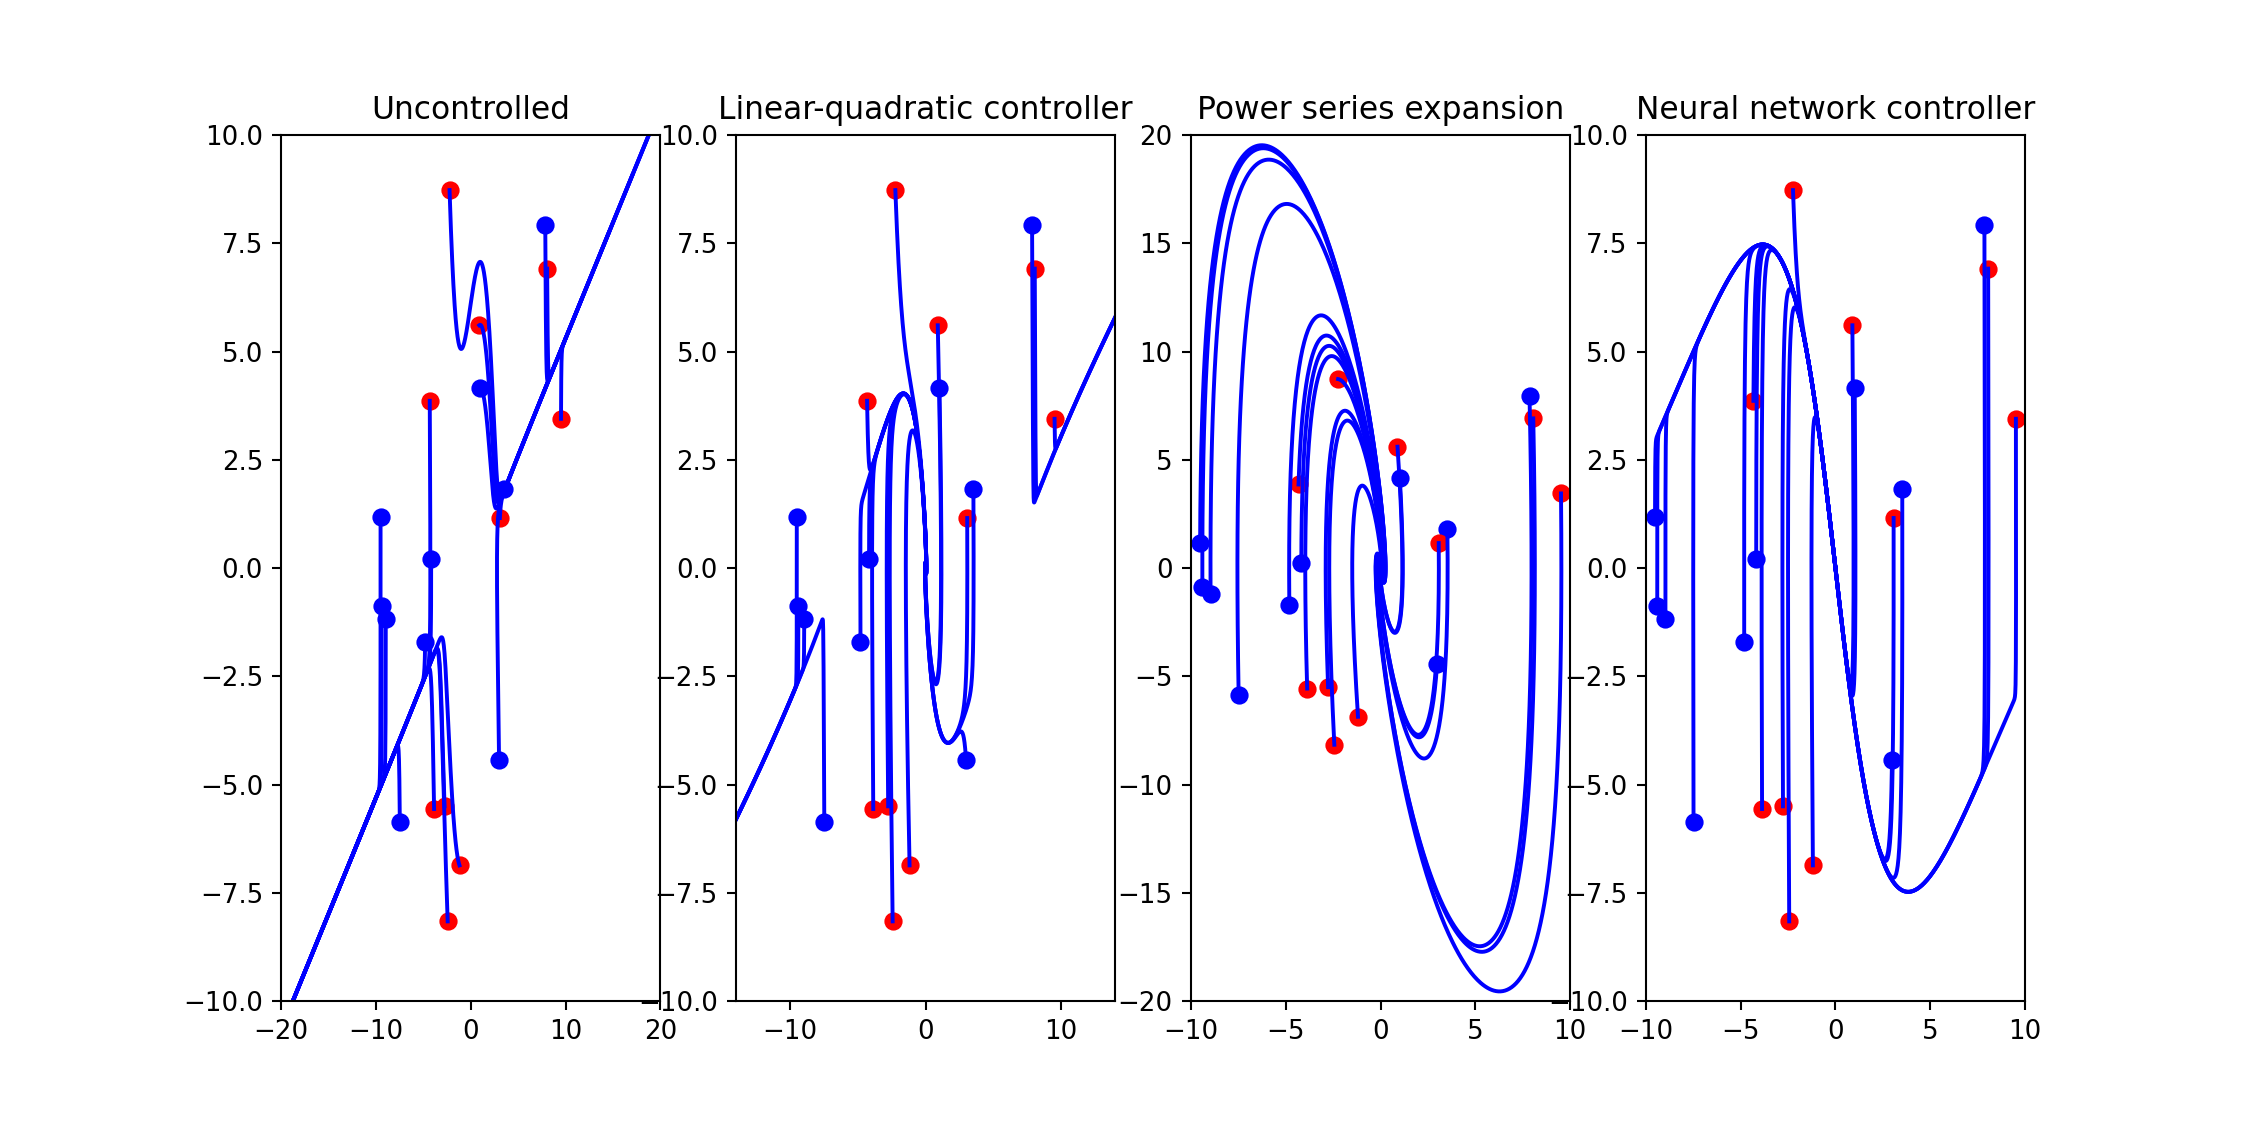

<IPython.core.display.Javascript object>


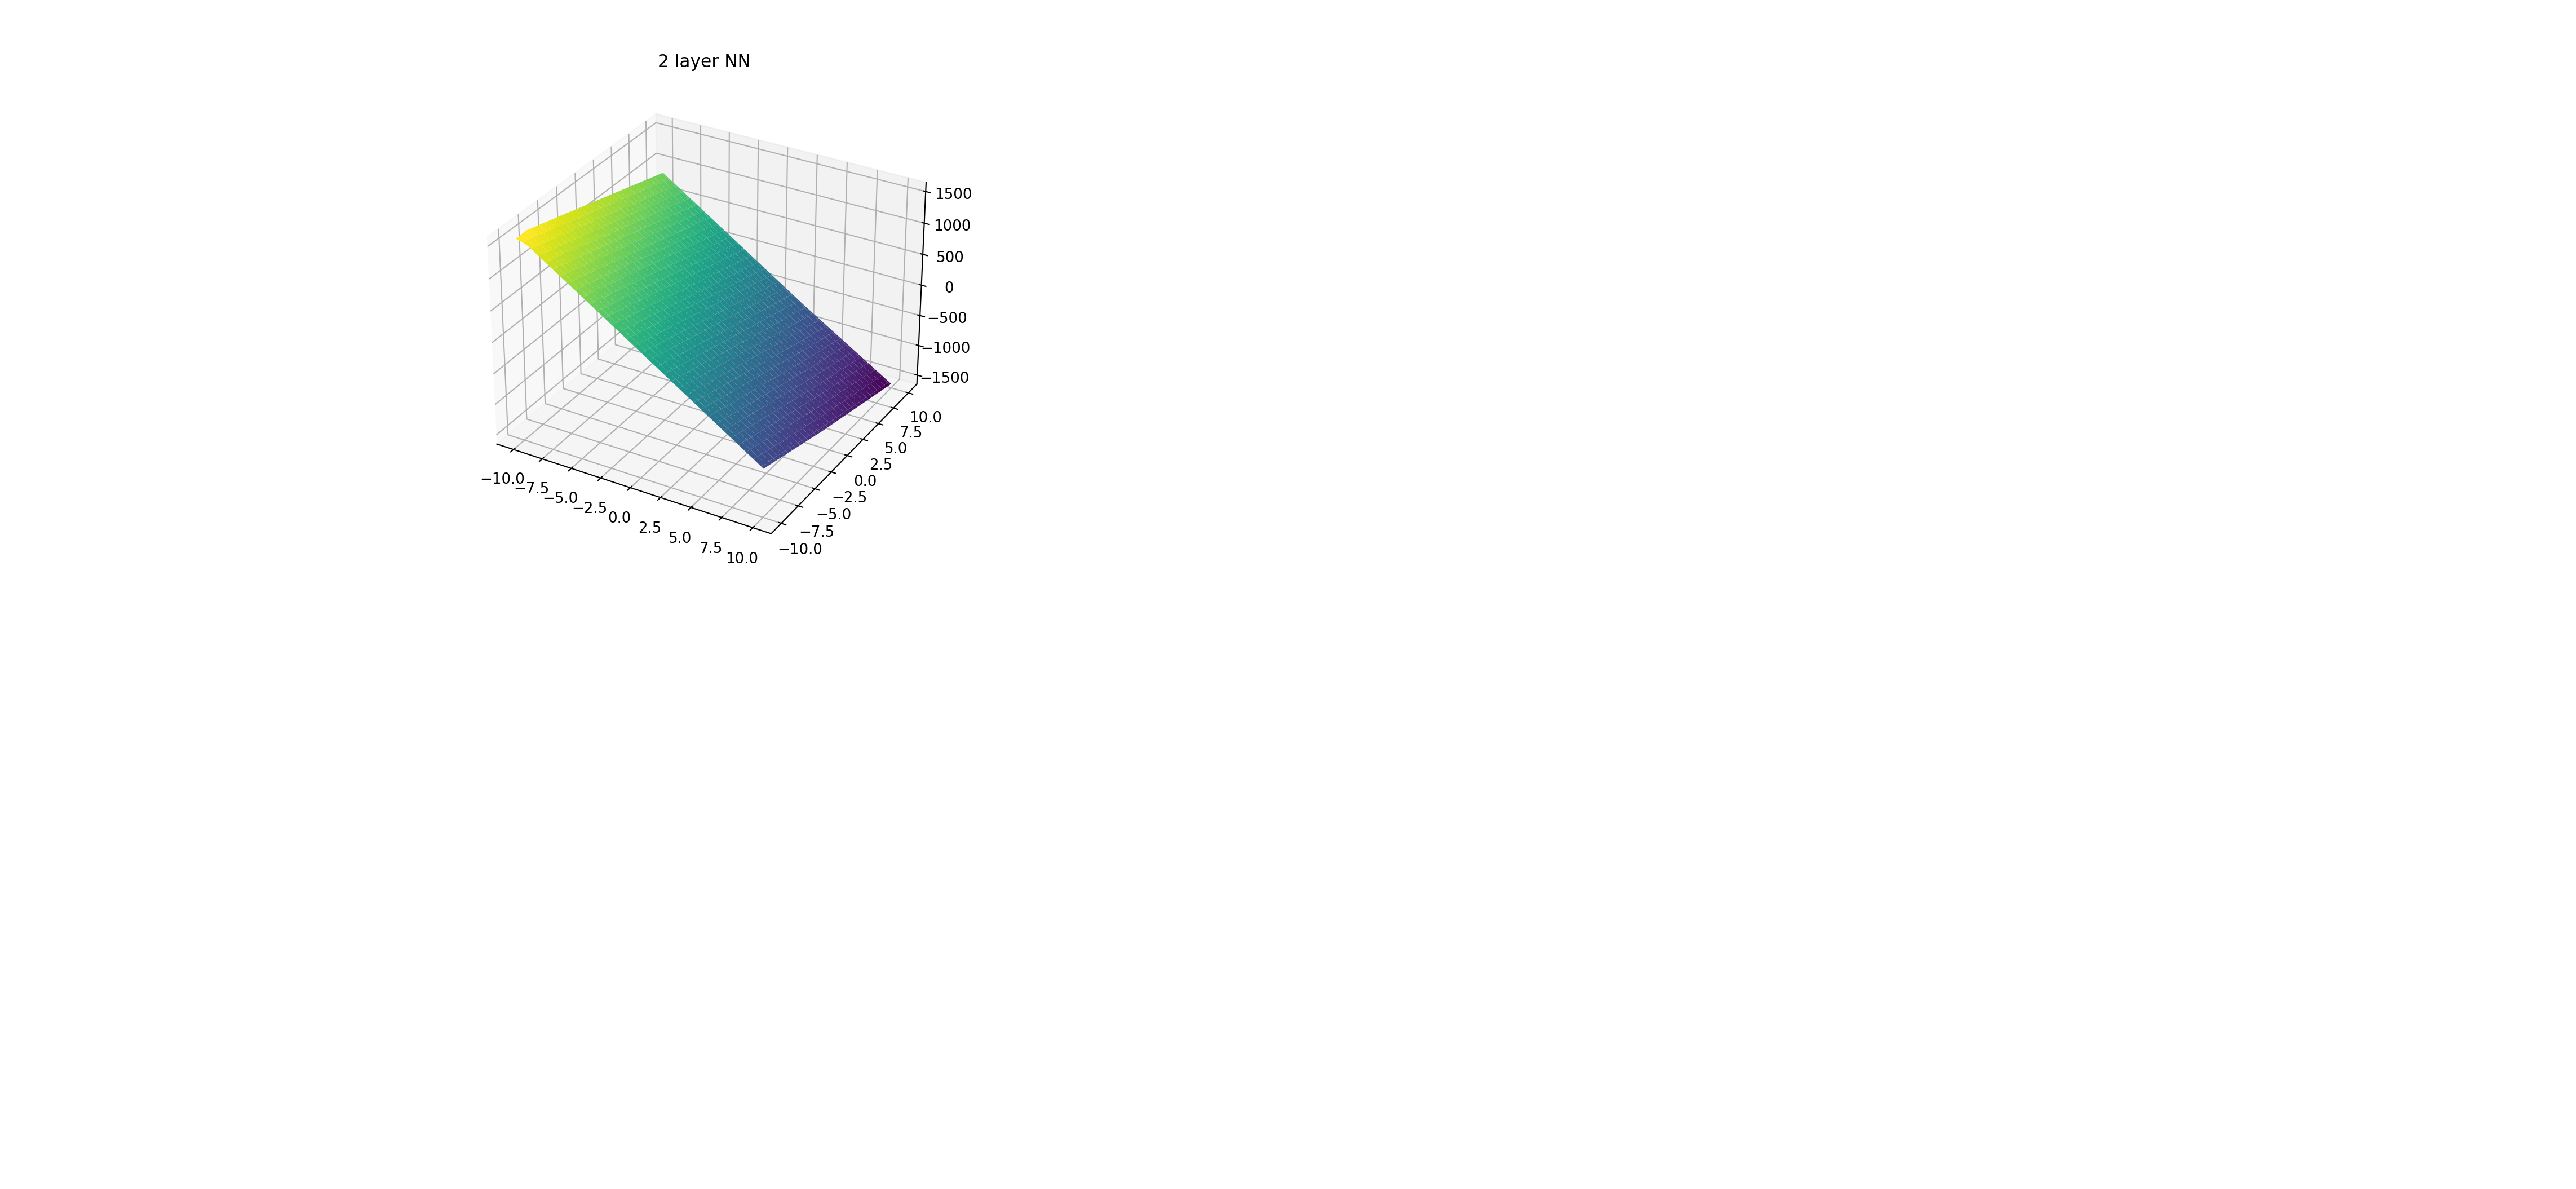

---------------------------------------- 
 Point:  [-7.37 -9.17]
Uncontrolled:
|Qy|: 1492.485205779326
|F(y)|: 0
J(y,F(y)): 1113756.0447350785

LQR:
|Qy|: 739.5039821957616
|F(y)|: 26389.502134659153
J(y,F(y)): 621635.9812992846

PSE:
|Qy|: 3.784038972255251
|F(y)|: 494.8738113105412
J(y,F(y)): 129.60952003228385

2 layer NN:
|Qy|: 4.816256030074027
|F(y)|: 62.431603461481316
J(y,F(y)): 13.547013628998036
---------------------------------------- 
 Point:  [ 2.04 -4.97]
Uncontrolled:
|Qy|: 220.72797636751304
|F(y)|: 0
J(y,F(y)): 24360.419775648697

LQR:
|Qy|: 0.8524465290271624
|F(y)|: 8.030187259482059
J(y,F(y)): 0.39557449613640244

PSE:
|Qy|: 0.7556289986075629
|F(y)|: 15.741351868633487
J(y,F(y)): 0.40938267109439963

2 layer NN:
|Qy|: 0.8319428494820057
|F(y)|: 62.431603461481316
J(y,F(y)): 2.2949170077879426
---------------------------------------- 
 Point:  [5.81 2.03]
Uncontrolled:
|Qy|: 1158.2113039362785
|F(y)|: 0
J(y,F(y)): 670726.7122828872

LQR:
|Qy|: 7.337377712901813
|F(y

<IPython.core.display.Javascript object>


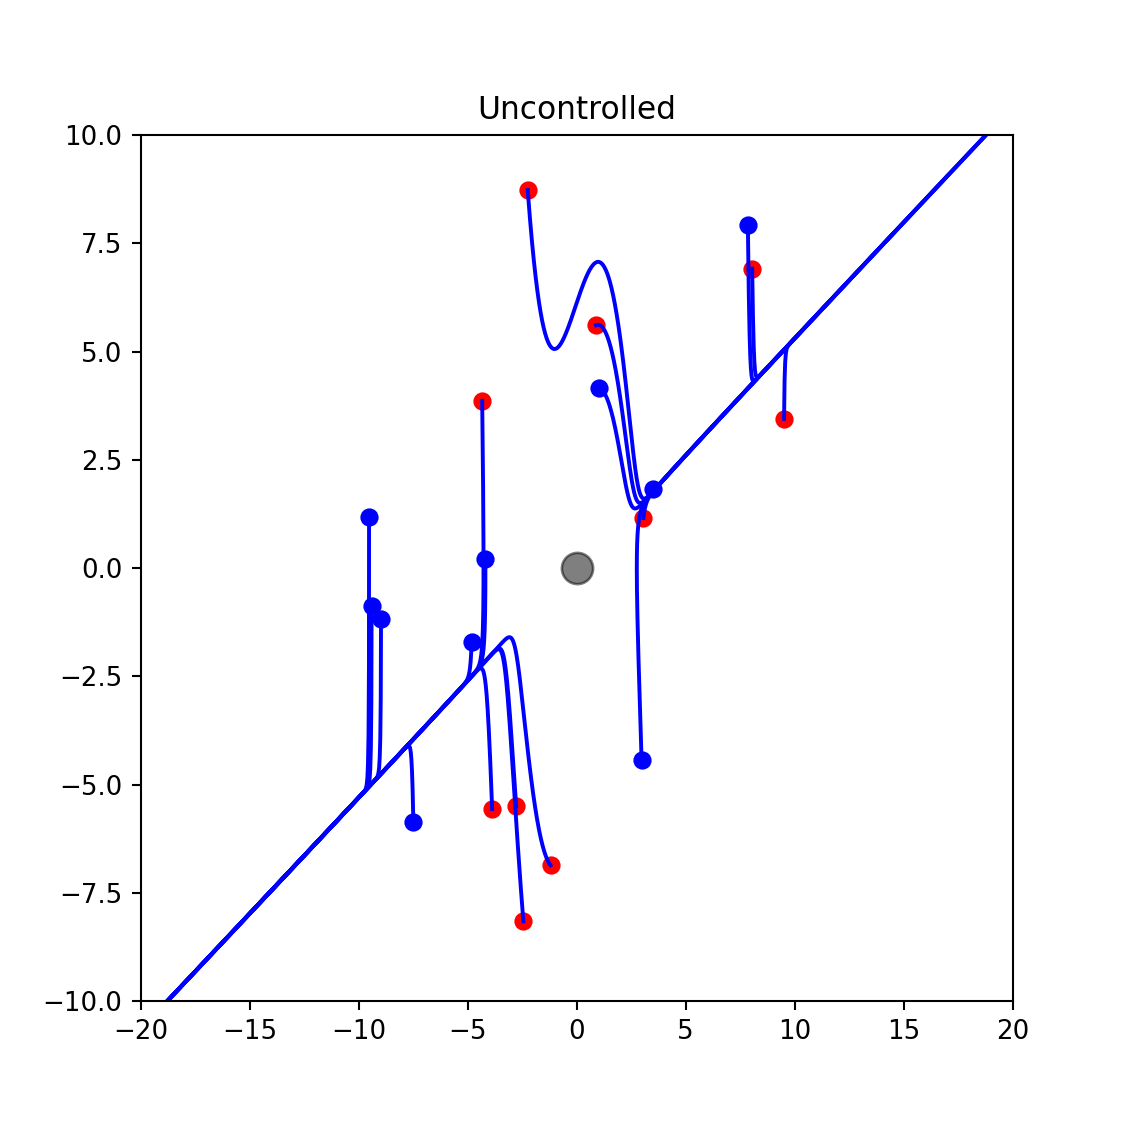

<IPython.core.display.Javascript object>


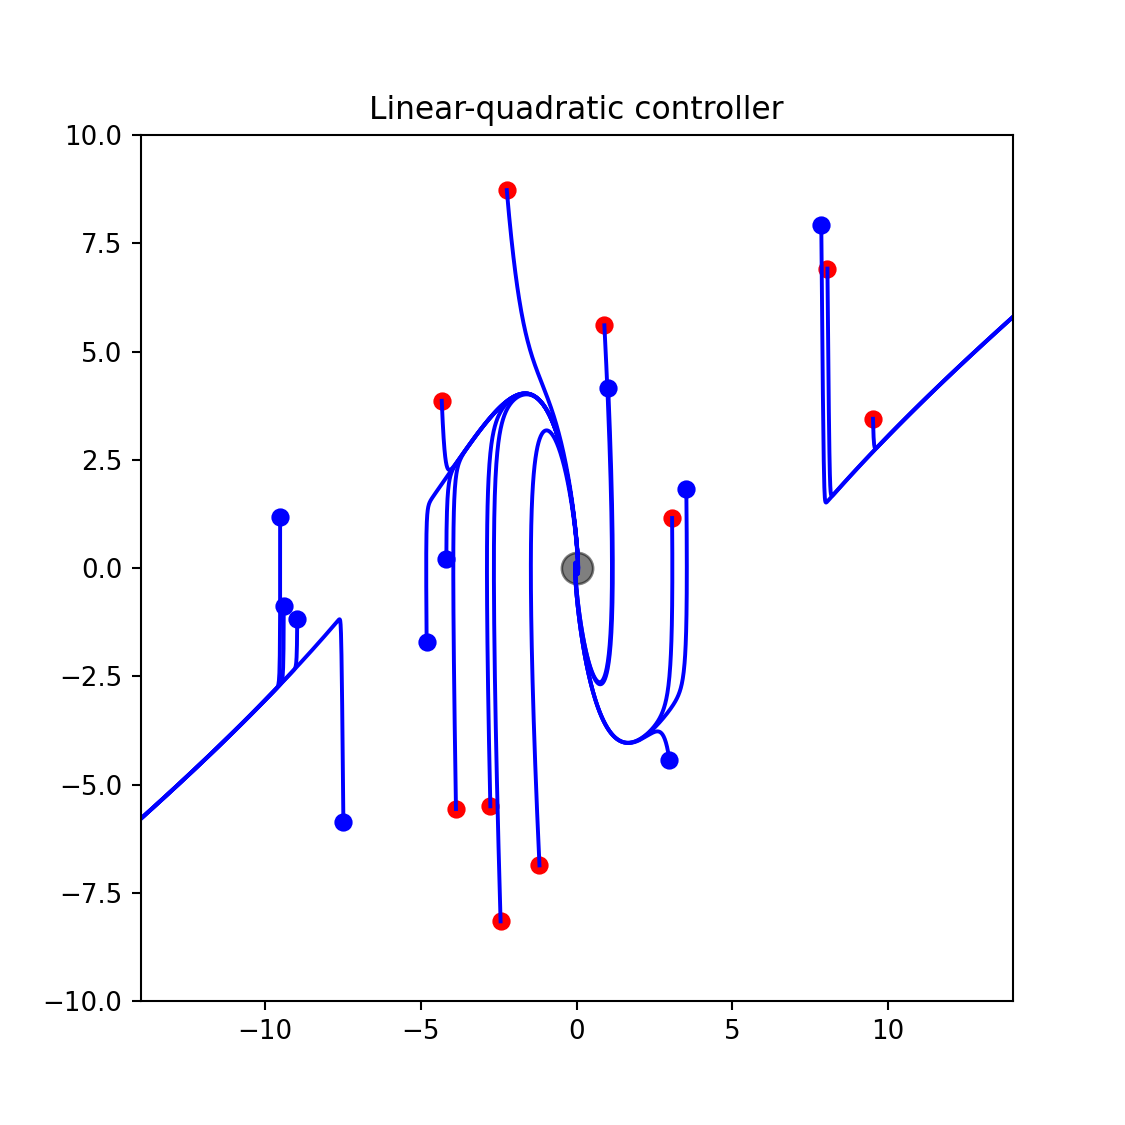

<IPython.core.display.Javascript object>


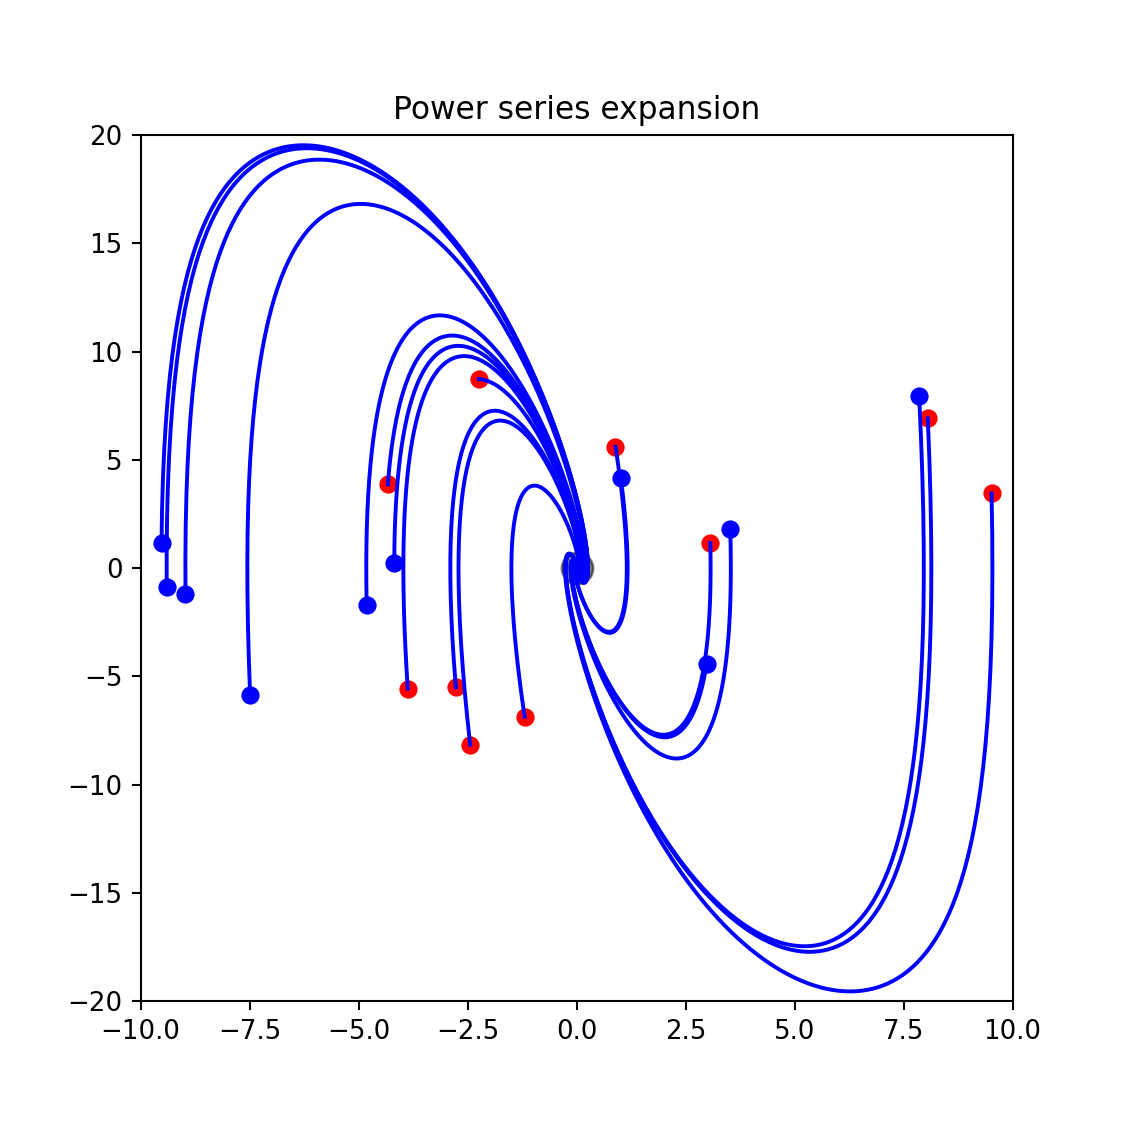

<IPython.core.display.Javascript object>


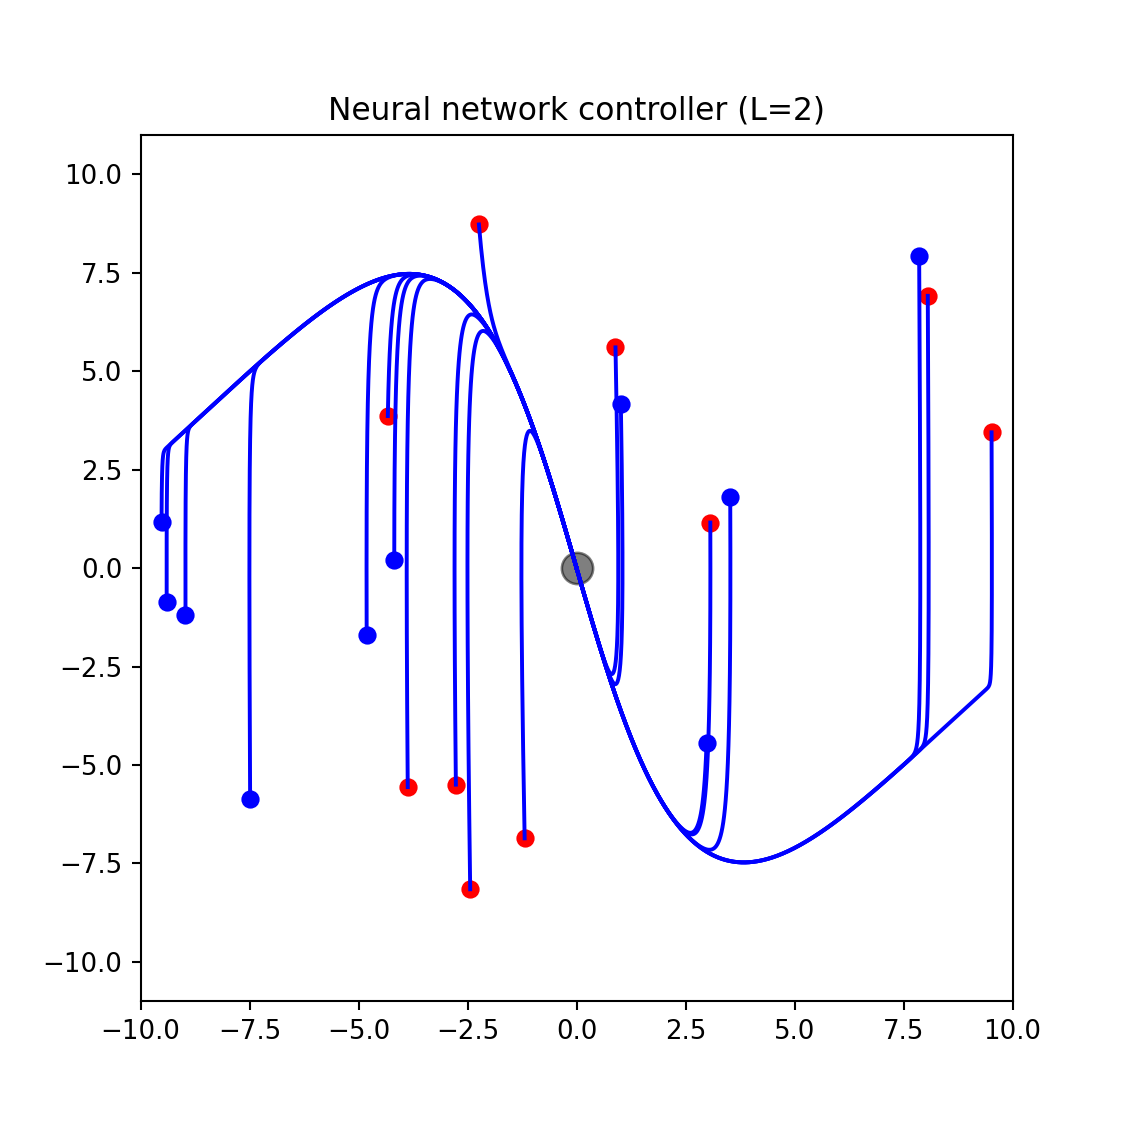

In [13]:
if example == 1:
    print('NN weights', Theta.theta[0])
    print('LQC weights', Wstar)
    
if example == 2:

    sol_NN = []
    for i in range(20):
        yi_0 = Y[i]

        sol = sp.integrate.solve_ivp(fun_state, (0,T), yi_0,
                                     method='BDF',
                                     rtol=eps,
                                     atol=eps,
                                     t_eval=tspace,
                                     args=(Theta,))
        #sol = solve_state(yi_0, theta)
        sol_NN.append(sol)
    fig, axs = plt.subplots(1, 4, figsize=[12,6])
    for ax in axs:
        ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
        ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')

    for i in range(20):
        for j, sol in enumerate([sol_unc, sol_LQR, sol_PSE, sol_NN]):
            axs[j].plot(sol[i].y[0], sol[i].y[1], color='b')

    axs[0].set(xlim=(-20,20),ylim=(-10,10))
    axs[0].set(title='Uncontrolled')
    axs[1].set(xlim=(-14,14),ylim=(-10,10))
    axs[1].set(title='Linear-quadratic controller')
    axs[2].set(xlim=(-10,10),ylim=(-20,20));
    axs[2].set(title='Power series expansion');
    axs[3].set(xlim=(-10,10),ylim=(-10,10));
    axs[3].set(title='Neural network controller');
    
    # Plot control
    y1lin = np.linspace(-10,10,101)
    y2lin = np.linspace(-10,10,101)
    y1, y2 = np.meshgrid(y1lin,y2lin)
    Ym = np.vstack([y1.flatten(),y2.flatten()])
    u_NN = np.array([F(Theta,y) for y in Ym.T])
    u_NN = u_NN.reshape(101,101)
    fig = plt.figure(figsize=(13,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(y1,y2,u_NN,cmap='viridis')
    ax.set_title('{} layer NN'.format(L));
    
    # Compare results
    for y0 in [np.array([-7.37, -9.17]), np.array([2.04, -4.97]), np.array([5.81, 2.03]), np.array([-3.31, -7.61])]:
        print('-'*40, '\n Point: ', y0)

        Tlong = 10
        tlong = np.linspace(0,Tlong,401)
        dt = tlong[1]-tlong[0]

        sol = sp.integrate.solve_ivp(fun_uncontrolled, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong)
        def tint(z):
            return np.sqrt(np.sum(np.sum(np.square(z),axis=0))*dt)

        def Jyu(Qyint, Fyint):
            return .5 * Qyint ** 2 + beta/2 * Fyint ** 2

        print('Uncontrolled:')
        Qyint = tint(Q@sol.y)
        Fyint = 0
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))

        sol = sp.integrate.solve_ivp(fun_LQR, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong)
        print('\nLQR:')
        Qyint = tint(Q@sol.y)
        Fyint = tint(F_LQR(sol.y))
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))

        sol = sp.integrate.solve_ivp(fun_PSE, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong)
        print('\nPSE:')
        Qyint = tint(Q@sol.y)
        Fyint = tint(np.array([F_PSE(y) for y in sol.y.T]))
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))



        sol = sp.integrate.solve_ivp(fun_state, (0,Tlong), y0,
                                     method='BDF',
                                     rtol=eps, atol=eps, t_eval=tlong, args=(Theta,))
        print('\n{} layer NN:'.format(L))
        Qyint = tint(Q@sol.y)
        Fyint = tint(F(Theta,y))
        print('|Qy|: {}\n|F(y)|: {}\nJ(y,F(y)): {}'.format(Qyint, Fyint, Jyu(Qyint, Fyint)))
    # Plot paths of uncontrolled system
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')    
    ax.set(xlim=(-20,20),ylim=(-10,10))
    ax.set(title='Uncontrolled')
    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_unc:
        ax.plot(sol.y[0], sol.y[1], color='b')


    if savefig:
        plt.savefig('images/VdP_Paths_uncontrolled_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)

    # Plot paths of linearly controlled system
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')    
    ax.set(xlim=(-14,14),ylim=(-10,10))
    ax.set(title='Linear-quadratic controller')
    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_LQR:
        ax.plot(sol.y[0], sol.y[1], color='b')

    if savefig:
        plt.savefig('images/VdP_Paths_LQR_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)

    # Plot paths of PSE controlled system
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o') 
    ax.set(xlim=(-10,10),ylim=(-20,20));
    ax.set(title='Power series expansion');
    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_PSE:
        ax.plot(sol.y[0], sol.y[1], color='b')

    if savefig:
        plt.savefig('images/VdP_Paths_PSE_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    
    # Plot paths of NN controller
    fig, ax = plt.subplots(1, 1, figsize=[6,6])
    ax.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    ax.scatter(Yval[:,0], Yval[:,1], color='r', marker='o') 
    ax.set(xlim=(-10,10),ylim=(-11,11));
    ax.set(title='Neural network controller (L={})'.format(L));

    ax.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for sol in sol_NN:
        ax.plot(sol.y[0], sol.y[1], color='b')

    if savefig:
        plt.savefig('images/VdP_Paths_NN_L_{}_{}.pdf'.format(L, poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    
    # Plot comparison
    if plot_comparison:
        Tlong = 10
        tlong = np.linspace(0,Tlong,401)
        dt = tlong[1]-tlong[0]

        def tint(z):
            return np.sqrt(np.sum(np.sum(np.square(z),axis=0))*dt)

        def Jyu(Qyint, Fyint):
            return .5 * Qyint ** 2 + beta/2 * Fyint ** 2

        junc = []
        jlqr = []
        jpse = []
        jnn1 = []
        jnn2 = []

        for y0 in Ym.T:
            print(y0)
            sol = sp.integrate.solve_ivp(fun_uncontrolled, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong)

            Qyint = tint(Q@sol.y)
            Fyint = 0
            junc.append(Jyu(Qyint, Fyint))

            sol = sp.integrate.solve_ivp(fun_LQR, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong)
            Qyint = tint(Q@sol.y)
            Fyint = tint(F_LQR(sol.y))
            jlqr.append(Jyu(Qyint, Fyint))


            sol = sp.integrate.solve_ivp(fun_PSE, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong)
            Qyint = tint(Q@sol.y)
            Fyint = tint(np.array([F_PSE(y) for y in sol.y.T]))
            jpse.append(Jyu(Qyint, Fyint))

            sol = sp.integrate.solve_ivp(fun_state, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong, args=(Theta_lin,))
            Qyint = tint(Q@sol.y)
            Fyint = tint(F(Theta_lin,y))
            jnn1.append(Jyu(Qyint, Fyint))

            sol = sp.integrate.solve_ivp(fun_state, (0,Tlong), y0,
                                         method='BDF',
                                         rtol=eps, atol=eps, t_eval=tlong, args=(Theta,))
            Qyint = tint(Q@sol.y)
            Fyint = tint(F(Theta,y))
            jnn2.append(Jyu(Qyint, Fyint))

        # Finally, produce plot
        Junc = np.array(junc).reshape(101,101)
        Jlqr = np.array(jlqr).reshape(101,101)
        Jpse = np.array(jpse).reshape(101,101)

        Jnn1 = np.array(jnn1).reshape(101,101)
        Jnn2 = np.array(jnn2).reshape(101,101)

        Tmp=np.array([jlqr,jpse,jnn1,jnn2])

        fig = plt.figure(figsize=(13,6))
        ax = fig.add_subplot(111)
        #, projection='3d')
        #ax.plot_surface(y1,y2,Jlqr<Jnn1,cmap='viridis')
        cax = ax.imshow(np.argmin(Tmp.T,axis=1).reshape(101, 101), extent=[-10,10,-10,10])
        #, cmap='viridis')
        ax.set_title('Cost optimal controller'.format(L));
        #ax.set_xlabel('x')
        #ax.set_ylabel('y')
        #ax.legend(['test'])
        cbar = fig.colorbar(cax, ticks=[0, 1, 2, 3]);
        cbar.ax.set_yticklabels(['LQR', 'PSE', 'NN-1', 'NN-2']);
        if savefig:
            plt.savefig('images/VdP_Comparison_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
                transparent=True, bbox_inches='tight', pad_inches=0.1)
        
if example == 3:
    def fun_NN(t, y):
        return fun_state(t, y, Theta)

    sol_NN = []
    Ynow = np.vstack([Ytrain,Yval])
    for i,_ in enumerate(Ynow):
        yi_0 = Ynow[i]

        sol = sp.integrate.solve_ivp(fun_NN, (0,T), yi_0,
                                 method='BDF',
                                 rtol=eps, atol=eps, t_eval=tspace)
        sol_NN.append(sol)

    fig, axs = plt.subplots(1, 1, figsize=[10,6])
    axs.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    axs.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')
    axs.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)

    for i in range(20):
        axs.plot(sol_NN[i].y[0], sol_NN[i].y[1], color='b')

    nd = 100
    axs.set(xlim=(-12,2),ylim=(-8,8));
    axs.set(title='{}-layer NN controller'.format(L));
    xc = np.linspace(c[0]-rad,c[0]+rad,nd+1)
    yc = -np.sqrt(rad**2-(xc-c[0])**2)
    axs.fill_between(xc, yc, -yc)
    if savefig:
        plt.savefig('images/Collision_Paths_w_penalty_beta_high_L_{}_{}.pdf'.format(L, poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    # Plot control
    y1lin = np.linspace(-10,10,nd+1)
    y2lin = np.linspace(-10,10,nd+1)
    y1, y2 = np.meshgrid(y1lin,y2lin)
    Ym = np.vstack([y1.flatten(),y2.flatten()])
    u_NN = np.array([F(Theta,y) for y in Ym.T])
    u_NN1 = u_NN[:,0].reshape(nd+1,nd+1)
    u_NN2 = u_NN[:,1].reshape(nd+1,nd+1)
    
    if False:
        col = np.array([ypenalty(y) for y in Ym.T])
        u_NN1 = col.reshape(nd+1,nd+1)
    
        col = np.array([Dypenalty(y) for y in Ym.T])
        u_NN1 = col[:,1].reshape(nd+1,nd+1)
        u_NN2 = col[:,1].reshape(nd+1,nd+1)

    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.plot_surface(y1,y2,u_NN1,cmap='viridis')
    ax.set_title('x Control');
    ax = fig.add_subplot(122, projection='3d')
    ax.plot_surface(y1,y2,u_NN2,cmap='viridis')
    ax.set_title('y Control');
    if savefig:
        plt.savefig('images/Collision_Control_w_penalty_beta_high_L_{}_{}.pdf'.format(L, poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
        
    # Find out time at which state x becomes close to zero
    #sol_NN[1].t[np.where(np.abs(sol_NN[1].y[0])<1e-3)[0][0]]
    
if example == 4:
    
    def fun_NN(t, y):
        return fun_state(t, y, Theta)

    sol_NN = []
    Ynow = np.vstack([Ytrain,Yval])
    for i,_ in enumerate(Ynow):
        yi_0 = Ynow[i]

        sol = sp.integrate.solve_ivp(fun_NN, (0,T), yi_0,
                                 method=ODESolver,
                                 rtol=eps,
                                 atol=eps,
                                 t_eval=tspace)
        sol_NN.append(sol)

    fig, axs = plt.subplots(1, 1, figsize=[10,6])
    axs.scatter(Ytrain[:,0],Ytrain[:,1],color='b',marker='o')
    axs.scatter(Yval[:,0], Yval[:,1], color='r', marker='o')

    # Plot paths training data
    for i in range(N):
        axs.plot(sol_NN[i].y[0], sol_NN[i].y[1])

        
    axs.set(xlim=(-11,2),ylim=(-5,5));
    axs.set(title='{}-layer NN controller'.format(L));
    axs.plot(np.array(0), np.array(0), color='k', marker='o', markersize=12, alpha=.5)
    
    if savefig:
        plt.savefig('images/CarModel_Paths_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    # Plot paths of validation data
    for i in range(N,2*N):
        axs.plot(sol_NN[i].y[0], sol_NN[i].y[1])

    if savefig:
        plt.savefig('images/CarModel_Paths_Val_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
        
        
    # Plot state trajectories
    fig, axs = plt.subplots(d, 1, figsize=[5,10])

    Irange = [0,1,2,3]

    for i in range(d):
        for j in range(4):
            axs[i].plot(sol_NN[j].t, sol_NN[j].y[i])

    axs[0].set(xlim=(-.1, 10.1),ylim=(-10,5), ylabel='$x$ position');
    axs[0].plot(np.array([0, T]), np.array([0,0]), 'b--', alpha=0.5);
    axs[1].set(xlim=(-.1, 10.1),ylim=(-5,5), ylabel='$y$ position');
    axs[1].plot(np.array([0, T]), np.array([0,0]), 'b--', alpha=0.5);
    axs[2].set(xlim=(-.1, 10.1),ylim=(-np.pi, np.pi), ylabel='$\psi$ yaw angle');
    axs[3].set(xlim=(-.1, 10.1),ylim=(-1, 5), ylabel='$v$ velocity');
    axs[3].plot(np.array([0, T]), np.array([0,0]), 'b--', alpha=0.5);
    axs[4].set(xlim=(-.1, 10.1),ylim=(-np.pi/2, np.pi/2), ylabel='$\delta$ steering angle');
    axs[4].plot(np.array([0, T]), np.array([deltamax, deltamax]), 'r--', alpha=0.5);
    axs[4].plot(np.array([0, T]), np.array([-deltamax, -deltamax]), 'r--', alpha=0.5);

    if savefig:
        plt.savefig('images/CarModel_State_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)
    
    # Plot control trajectories
    fig, axs = plt.subplots(m, 1, figsize=[5,4])

    for j in Irange:
        Fy = np.array([F(Theta, y) for y in sol_NN[j].y.T])
        axs[0].plot(sol_NN[j].t, Fy[:,0])
        axs[1].plot(sol_NN[j].t, Fy[:,1])
    axs[0].set(xlim=(-.1, 10.1), ylabel='$a$ acceleration');
    axs[1].set(xlim=(-.1, 10.1), ylabel='$w_\delta$ steering angle velocity');

    if savefig:
        plt.savefig('images/CarModel_Control_{}.pdf'.format(poststr), dpi=300, facecolor='w', edgecolor='w',
            transparent=True, bbox_inches='tight', pad_inches=0.1)

In [16]:
Theta.theta

[array([[-49.04937972,  15.23980619]]),
 array([[ 1.35732825,  0.95338087],
        [-0.44274698, -0.30417305]]),
 array([21.91354995,  4.08705365])]

In [17]:
Theta_save = copy.deepcopy(Theta)

In [18]:
Theta = copy.deepcopy(Theta_save)